In [60]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from email.message import EmailMessage
import imghdr
import smtplib

In [3]:
# block to setup BQ
import os
import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage

os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 

# Explicitly create a credentials object. This allows you to use the same
# credentials for both the BigQuery and BigQuery Storage clients, avoiding
# unnecessary API calls to fetch duplicate authentication tokens.
credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

# Make clients.
bqclient = bigquery.Client(credentials=credentials, project='wx-bq-poc',)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

# build comparison code
* compare normalised prob
* compare inc sales (default to email as well as others)

In [85]:
def convert_to_post_MTA_format(fpath_results,
                               campaign_code,
                               fw,
                               dacamp_prod_mc_final="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final`",
                               rm_fb=True,
                               create_dacamp_prod_mc_final=False):
    """
    Overview
        Convert output from MTA package into post MC format in Safari (for downstream processing to MC CRN level).
        Saves to BQ.
    Arguments
        fpath_results - filepath to CSV with channel attribution, MTA package output
        campaign_code - e.g. "CVM-1661"
        fw - financial week, e.g. "2021-04-12"
        dacamp_prod_mc_final - where to save MC attribution in post MTA format, BQ table
    Returns
        table saved to BQ
    """
    df = pd.read_csv(fpath_results)
    
    print("\tremoving facebook touchpoints from MC output")
    if rm_fb:  # rm fb touchpoints and rescale everything back up to 100%
        conversion_value_fb = df.loc[(df.channel_name == "FB_Click") | (df.channel_name == "FB_Impression"), "normalised_conversion_value"].sum()
        conversion_value_non_fb = df.loc[(df.channel_name != "FB_Click") & (df.channel_name != "FB_Impression"), "normalised_conversion_value"].sum()
        scaling = 1 / conversion_value_non_fb
        df.loc[:, "normalised_conversion_value"] = scaling * df.loc[:, "normalised_conversion_value"]
        df = df[(df.channel_name != "FB_Click") & (df.channel_name != "FB_Impression")]

    
    df = df.drop("Unnamed: 0", axis="columns")

    df.loc[:, "event"] = df.channel_name.str.extract(r"(.*)_(\d{4}-\d{2}-\d{2})_(\d{4}-\d{2}-\d{2})").iloc[:, 0]
    df.loc[:, "campaign_start_date"] = df.channel_name.str.extract(r"(.*)_(\d{4}-\d{2}-\d{2})_(\d{4}-\d{2}-\d{2})").iloc[:, 1]
    df.loc[:, "campaign_end_date"] = df.channel_name.str.extract(r"(.*)_(\d{4}-\d{2}-\d{2})_(\d{4}-\d{2}-\d{2})").iloc[:, 2]

    # extract channel, medium, event from full MC node name
    event_extract = df.channel_name.str.extract(r"({campaign_code}|CVM-1661|_AlwaysOn)_(display|email|rw_app|google_other|sem|wow_web|rw_web_oap|video)(_brand|_generic|_other|_shopping)?_(clk|open|imp|view)".format(campaign_code=campaign_code)).fillna("")
    event_extract

    df.loc[:, "channel"] = event_extract.iloc[:, 0] + "_" + event_extract.iloc[:, 1]
    df.loc[:, "medium"] = event_extract.iloc[:, 0] + "_" + event_extract.iloc[:, 1] + event_extract.iloc[:, 2]
   
    df.loc[:, "key"] = "Total_supermarkets_" + campaign_code + "_" + df.loc[:, "campaign_start_date"] + '_' + df.loc[:, "campaign_end_date"]
    df.loc[:, "banner"] = "supermarkets"
    df.loc[:, "campaign_code"] = campaign_code
    df = df.rename({"normalised_conversion_value":"channel_prob_norm"}, axis="columns")
    
#     return df
    # check extraction went OK
    if df.isnull().sum().sum() != 0:
        print("ERROR: input dataframe has NANs... exiting")
        print(df)
        return df
    assert df.isnull().sum().sum() == 0
    
    # if there are channels that don't belong here
    if df[(df.channel == "_") | (df.medium == "_")].shape[0] > 0:
        conversion_amount_dropped = df[(df.channel == "_") | (df.medium == "_")].channel_prob_norm.sum()
        print("\tdropping the below rows from dacamp_prod_mc_final with conversion value of:", conversion_amount_dropped)
        print(df[(df.channel == "_") | (df.medium == "_")])
        assert df[(df.channel == "_") | (df.medium == "_")].channel_prob_norm.sum() < 0.05
        df = df[((df.channel != "_") & (df.medium != "_"))]
    
    print("\tdf generated for upload to BQ")

    # dump to BQ for downstream processing (convert to CRN level)
    df.to_gbq('personal.AL_FBAA_MC_mc_final_tmp', project_id='wx-bq-poc', if_exists='replace')
    
    if create_dacamp_prod_mc_final:
        comment_out = "#"
    else:
        comment_out = ""

    query_string = """
    -- generating dummy table
    create or replace table {dacamp_prod_mc_final} as
    
    {comment_out}select * from `wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_mc_final_{fw}` where campaign_code != "{campaign_code}";    
    {comment_out}INSERT INTO {dacamp_prod_mc_final}    
    
    select 
      key,
      banner,
      campaign_code,
      campaign_start_date,
      campaign_end_date,
      channel,
      medium,
      event,
      -1 as event_volume,
      -1 as event_reach,
      -1 as event_converted_crn,
      -1 as medium_reach,
      -1 as medium_converted_crn,
      channel_prob_norm
    from `wx-bq-poc.personal.AL_FBAA_MC_mc_final_tmp` where channel_prob_norm > 0;

    -- show header to check if it worked
    select * from {dacamp_prod_mc_final} where campaign_code = '{campaign_code}' limit 50;
    """.format(campaign_code=campaign_code, fw=fw, dacamp_prod_mc_final=dacamp_prod_mc_final, comment_out=comment_out)
    df_bq = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )
    print("\tpost MTA output uploaded to BQ")
    return df_bq

def run_post_MTA_processing(dacamp_prod_event_mw, dacamp_prod_activation, dacamp_prod_online_sales, marketable_crn,
                            dacamp_prod_mc_final, dacamp_prod_mc_final_crn, filter_campaign=None):
    """
    Overview
        Runs Shanglin's post MTA processing (create CRN level attribution, further adjustments)
        Based on:
        https://bitbucket.org/wx_rds/safari-prod/src/master/markov_chain/bq_query/mc/mc_camp_mcfinal_crn_base.sql
    Arguments
        dacamp_prod_event_mw - copy of Shanglin's events, a BQ table
        dacamp_prod_activation - copy of Shanglin's activations, a BQ table
        dacamp_prod_online_sales - copy of Shanglin's online activations, a BQ table
        marketable_crn - copy of marketable CRNs, a BQ table
        dacamp_prod_mc_final - post MTA output (e.g. this is the MC input to the post MTA process), a BQ table
        dacamp_prod_mc_final_crn - BQ table to save the CRN level (output of this process)
        filter_campaign - dacamp_prod_mc_final_crn filtered for that campaign only
    Returns
        An empty DF if successful
    """
    if filter_campaign:
        filter_campaign_comment = ""
        campaign_code = filter_campaign
    else:
        filter_campaign_comment = "--"
        campaign_code=""
    query_string = """
    ------------------------------------------------------
    -- REPLICATE SHANGLINS POST MTA CODE
    ------------------------------------------------------
    drop table if exists {dacamp_prod_mc_final_crn};
    create table {dacamp_prod_mc_final_crn} as
    (
        with onl_start_date as 
        (    
            select max(campaign_start_date) from {dacamp_prod_event_mw} where campaign_code = 'ONLINE'
        ),

        onl_end_date as 
        (
            select max(campaign_end_date) from {dacamp_prod_event_mw} where campaign_code = 'ONLINE'
        )

        SELECT distinct DATE_TRUNC(DATE_ADD((select * from onl_end_date),interval 0 day), week(Monday)) as week
            , c.crn
            , e.segment_cvm
            , e.segment_lifestage
            , f.segment_marketable
            , c.banner
            , c.campaign_code
            , c.campaign_type
            , c.campaign_start_date
            , c.campaign_end_date
            , c.tot_spend as total_sales
            , c.spend as inc_sales
            , channel_event
            , channel_prob_norm
            , case when a.channel is not null then a.channel else d.channel end as channel
            , case when a.medium is not null then a.medium else d.medium end as medium
            , case when a.event is not null then a.event else d.event end as event
            , case when channel_prob_norm is not null then channel_prob_norm / (sum(channel_prob_norm) OVER (PARTITION BY c.crn, b.key)) 
                    when channel_prob_norm is null and channel_event is not null then 0 
                    else 1 end as attributed_conversion
            , case when channel_prob_norm is not null then c.tot_spend * channel_prob_norm / (sum(channel_prob_norm) OVER (PARTITION BY c.crn, b.key)) 
                    when  channel_prob_norm is null and channel_event is not null then 0 
                    else c.tot_spend end as attributed_total_sales
            , case when channel_prob_norm is not null then c.spend * channel_prob_norm / (sum(channel_prob_norm) OVER (PARTITION BY c.crn, b.key)) 
                    WHEN channel_prob_norm is null and channel_event is not null then 0 
                     else c.spend end as attributed_inc_sales
        FROM
        (
            SELECT 
                concat('Total', '_', banner, '_', campaign_code, '_', cast(campaign_start_date as string), '_', cast(campaign_end_date as string)) as key
                , banner
                , crn
                , campaign_code
                , campaign_start_date
                , campaign_end_date
                , campaign_end_date_real
                , campaign_type
                , case when sum(tot_spend) is null then 0 else sum(tot_spend) end as tot_spend
                , case when sum(spend) is null then 0 else sum(spend) end as spend
            FROM
            (
                SELECT crn
                    , banner
                    , campaign_code
                    , campaign_start_date
                    , campaign_end_date
                    , campaign_end_date_real
                    , campaign_type
                    , min(time_utc) as conv_time
                    , sum(tot_spend) as tot_spend
                    , sum(spend) as spend
                FROM {dacamp_prod_activation}
                group by 1,2,3,4,5,6,7

                union all

                SELECT crn
                    , 'supermarkets' as banner
                    , 'ONLINE' as campaign_code
                    , (select * from onl_start_date) as campaign_start_date
                    , (select * from onl_end_date) as campaign_end_date
                    , (select * from onl_end_date) as campaign_end_date_real
                    , 'ONLINE' as campaign_type
                    , min(time_utc) as conv_time
                    , sum(tot_spend) as tot_spend
                    , sum(spend) as tot_spend
                FROM {dacamp_prod_online_sales}
                group by 1
            )
            {filter_campaign_comment} where campaign_code = "{campaign_code}"
            group by 1,2,3,4,5,6,7,8
        ) c 

        left join
        (        
            SELECT 
                concat('Total', '_', banner, '_', campaign_code, '_', cast(campaign_start_date as string), '_', cast(campaign_end_date as string)) as key
                , crn 
                , channel_event 
                , count(*) as event_volume
            FROM {dacamp_prod_event_mw} 
            group by 1,2,3
            order by 1,2,3
        ) b on b.key = c.key and b.crn = c.crn

        left join 
        (
            select *
        from {dacamp_prod_mc_final}
        ) a on a.key = b.key and a.event = b.channel_event 

        left join
        (
            SELECT a1.key
            , CASE WHEN channel is null and campaign_code not like '%NM%' then concat(SUBSTR(campaign_code,1,9), '_email') 
                    WHEN channel is null and campaign_code like '%NM%' then concat(SUBSTR(campaign_code,1,9), '_rw_app') 
                    else channel end as channel
            , CASE WHEN medium is null and campaign_code not like '%NM%' then concat(SUBSTR(campaign_code,1,9), '_email') 
                    WHEN medium is null and campaign_code like '%NM%' then concat(SUBSTR(campaign_code,1,9), '_rw_app') 
                    else medium end as medium
            ,  CASE WHEN event is null and campaign_code not like '%NM%' then concat(SUBSTR(campaign_code,1,9), '_email_open') 
                    WHEN event is null and campaign_code like '%NM%' then concat(SUBSTR(campaign_code,1,9), '_rw_app_imp') 
                    else event end as event
            , event_volume
            , event_reach
            , event_converted_crn
            , medium_reach
            , medium_converted_crn
            FROM
            (
                select distinct key, campaign_code
          from {dacamp_prod_mc_final}
            ) a1
            left join
            (    SELECT key
                    , channel
                    , medium
                    , event
                    , event_volume
                    , event_reach
                    , event_converted_crn
                    , medium_reach
                    , medium_converted_crn
          from {dacamp_prod_mc_final}
                where (campaign_code = 'ONLINE' and event like '%wow_web_view%')
                    or (campaign_code like '%NM%' and regexp_contains(event, r'(?i)rw_app_imp') and substr(event,1,9) = substr(campaign_code,1,9))
            or (campaign_code not like '%NM%' and campaign_code <> 'ONLINE' and regexp_contains(event, r'(?i)email_open') and substr(event,1,9) = substr(campaign_code,1,9))
            ) a2 on a1.key = a2.key
        ) d on c.key = d.key

        left join
        (
            SELECT crn, max(macro_segment_curr) as segment_cvm, max(lifestage) as segment_lifestage
            FROM `wx-bq-poc.wx_lty_digital_attribution_dev.redx_loyalty_customer_value_model`
            where Date(pw_end_date_utc) = (select max(Date(pw_end_date_utc)) from `wx-bq-poc.wx_lty_digital_attribution_dev.redx_loyalty_customer_value_model`)
            group by 1
        ) e on c.crn = e.crn

        left join
        (
            SELECT crn, max(marketable) as segment_marketable
            FROM {marketable_crn}
            group by 1
        ) f on c.crn = f.crn

    );
    """.format(dacamp_prod_event_mw=dacamp_prod_event_mw,
               dacamp_prod_activation=dacamp_prod_activation,
               dacamp_prod_online_sales=dacamp_prod_online_sales,
               marketable_crn=marketable_crn,
               dacamp_prod_mc_final=dacamp_prod_mc_final,
               dacamp_prod_mc_final_crn=dacamp_prod_mc_final_crn,
               filter_campaign_comment=filter_campaign_comment,
               campaign_code=campaign_code)
    df_bq = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )
    return df_bq

def get_post_MTA_inc_sales(campaign_code, data_date, groupby="channel", fpath_out=None):
    """
    Overview
        Grabs the final Safari post-MTA results (including manual FBAA run) from GCP
    Arguments
        campaign_code
        data_date - date of MTA run, check gs://digital-attribution-data/phase2/markov_out/
        groupby="channel"
        fpath_out=None
    Returns
        Dataframe of grouped post-MTA results
    """
    df = pd.read_csv('gs://digital-attribution-data/phase2/markov_out/' + data_date + '/mc_final_agg.csv')
    mask = (df.campaign_code == campaign_code) & (df.segment == "Total")
    df_group = df[mask].groupby(groupby).sum()
    df_group['attributed_inc_sales_percent'] = (df_group['attributed_inc_sales'] / df_group['attributed_inc_sales'].sum()) * 100
    if fpath_out:
        df_group.to_csv(fpath_out + "post_MTA_results_" + data_date + ".csv")
    return df_group

def compare_MTA_results(dacamp_prod_mc_final_crn_new, dacamp_prod_mc_final_crn_old, campaign_code, safari_run_date,
                       fpath_out, fw, send_email=False):    
    """
    Overview
        Compares CRN level post MTA results of the old and new method.
    Arguments
        dacamp_prod_mc_final_crn_new
        dacamp_prod_mc_final_crn_old
        campaign_code
        safari_run_date
    Returns
        Dataframe of comparison results (old vs. new method)
    """
    query_string = """
    -- new MTA results vs old
    with results_AL as (  -- new results
    SELECT
      campaign_code,
      campaign_start_date,
      channel,
      medium,
      event,
      coalesce(channel_event, "DEFAULT") as channel_event,
      AVG(channel_prob_norm) as channel_prob_norm,
      sum(attributed_inc_sales) as attributed_inc_sales,
      count(*) as count
    FROM {dacamp_prod_mc_final_crn_new}
    where campaign_code = "{campaign_code}"
    and channel is not null
    and attributed_inc_sales != 0
    group by 1,2,3,4,5,6
    order by 1,2,3,4,5,6
    ),
    results_Shanglin as (
    SELECT
      campaign_code,
      campaign_start_date,
      channel,
      medium,
      event,
      coalesce(channel_event, "DEFAULT") as channel_event,
      AVG(channel_prob_norm) as channel_prob_norm,
      sum(attributed_inc_sales) as attributed_inc_sales,
      count(*) as count
    FROM {dacamp_prod_mc_final_crn_old}
    where campaign_code = "{campaign_code}"
    and channel is not null
    and attributed_inc_sales != 0
    group by 1,2,3,4,5,6
    order by 1,2,3,4,5,6
    )
    select
      coalesce(a.campaign_code, b.campaign_code) as campaign_code,
      coalesce(a.campaign_start_date, b.campaign_start_date) as campaign_start_date,
      coalesce(a.channel, b.channel) as channel,
      coalesce(a.medium, b.medium) as medium,
      coalesce(a.event, b.event) as event,
      coalesce(a.channel_event, b.channel_event) as channel_event,
      a.channel_prob_norm as channel_prob_norm_AL,
      b.channel_prob_norm as channel_prob_norm_shanglin,
      a.attributed_inc_sales as attributed_inc_sales_AL,
      b.attributed_inc_sales as attributed_inc_sales_shanglin,
      a.count as count_AL,
      b.count as count_shanglin
    from results_AL as a
    full outer join results_Shanglin as b
      on a.event = b.event and a.channel_event = b.channel_event and a.campaign_start_date = b.campaign_start_date
    order by coalesce(a.campaign_start_date, b.campaign_start_date), coalesce(a.event, b.event), coalesce(a.channel_event, b.channel_event)
    ;
    """.format(dacamp_prod_mc_final_crn_new=dacamp_prod_mc_final_crn_new, dacamp_prod_mc_final_crn_old=dacamp_prod_mc_final_crn_old,
               campaign_code=campaign_code)

    results = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )
    
    results.loc[:, "channel"] = results.channel.str.strip("_")
    results.loc[:, "medium"] = results.medium.str.strip("_")
    results.loc[:, "event"] = results.event.str.strip("_")
    
    plt.title("MTA results current vs new " + campaign_code + ": " + fw)
    sns.regplot(x="attributed_inc_sales_AL", y="attributed_inc_sales_shanglin", data=results)
    plt.savefig(fpath_out + "_comp_scatter_" + campaign_code + "_" + fw +  ".png")
    plt.show()    
    
    plt.title("MTA results current vs new (excluding default channel) " + campaign_code + ": " + fw)
    sns.regplot(x="attributed_inc_sales_AL", y="attributed_inc_sales_shanglin", data=results[results.channel_event != "DEFAULT"])    
    plt.savefig(fpath_out + "_comp_scatter_ex_def_channel_" + campaign_code + "_" + fw +  ".png")
    plt.show()
    
    # pull in final results from Safari, saved to GCP    
    results_comparison = pd.merge(left=results.groupby("event").sum(), right=get_post_MTA_inc_sales(campaign_code, safari_run_date, groupby="event"),
                                  how="outer", on="event").loc[:, ['channel_prob_norm_AL', 'channel_prob_norm_shanglin', 'attributed_inc_sales_AL', 'attributed_inc_sales_shanglin', 'attributed_inc_sales']]
    results_comparison = results_comparison.rename({"attributed_inc_sales":"attributed_inc_sales_safari"}, axis="columns")   
    
    plt.title("MTA results current Safari vs new (grouped) " + campaign_code + ": " + fw)
    sns.regplot(x="attributed_inc_sales_AL", y="attributed_inc_sales_safari", data=results_comparison)
    plt.savefig(fpath_out + "_comp_scatter_grouped_" + campaign_code + "_" + fw +  ".png")
    plt.show()    
    
    plt.subplots(figsize=(30, 15))
    plt.title("MTA results current vs new " + campaign_code + ": " + fw)
    sns.heatmap(results_comparison.loc[:, ['attributed_inc_sales_AL', 'attributed_inc_sales_shanglin', 'attributed_inc_sales_safari']], cmap='cividis', annot=True, fmt=".2f")
    plt.savefig(fpath_out + "_comp_heatmap_" + campaign_code + "_" + fw +  ".png")
    plt.show()    
    
    results_comparison.loc["Total",:] = results_comparison.sum(numeric_only=True)
    
    if send_email:
        # send out e-mail with results
        EmailAdd = "woolworths.bot001@gmail.com" #senders Gmail id over here
        Pass = "%JKg5rtwoPZ*v&fUxe8U" #senders Gmail's Password over here 
        EMAIL_RECIPIENTS = 'alau3@woolworths.com.au'  # recipients, separated by a comma
        
        msg = EmailMessage()
        msg['Subject'] = 'wow.bot🤖: RESULTS FOR MTA with FB run for fw ' +  fw + ": " + campaign_code # Subject of Email
        msg['From'] = EmailAdd
        msg['To'] = EMAIL_RECIPIENTS # Reciver of the Mail
        msg.set_content("""
        Results saved here:
        `{output_table}`
        Comparison of old and new MTA FB method
        {results}
        """.format(output_table=dacamp_prod_mc_final_crn_new, 
                   results=str(results))) # Email body or Content

        with open(fpath_out + "_comp_heatmap_" + campaign_code + "_" + fw +  ".png", 'rb') as fp:
            img_data = fp.read()
        msg.add_attachment(img_data, maintype='image',
                                     subtype=imghdr.what(None, img_data))

        #### >> Code from here will send the message << ####
        with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp: #Added Gmails SMTP Server
            smtp.login(EmailAdd,Pass) #This command Login SMTP Library using your GMAIL
            smtp.send_message(msg) #This Sends the message
    
    return results, results_comparison

def allocate_fb_inc_sales(campaign_code, campaign_start_date, campaign_end_date, fpath_results, dacamp_prod_mc_final_crn_w_fb,
                          dacamp_prod_mc_final_crn, increase_inc_sales=False):
    """
    Overview
        Increase the size of the pie (discovered via Xueyuan's FBAA bit).
    """
    # extract scaling factor from package results
    df = pd.read_csv(fpath_results)
    attr_fb = df[(df.channel_name == "FB_Click") | (df.channel_name == "FB_Impression")].normalised_conversion_value.sum()
    attr_non_fb = df[(df.channel_name != "FB_Click") & (df.channel_name != "FB_Impression")].normalised_conversion_value.sum()
    fb_scaling = attr_fb / attr_non_fb
    
    attr_fb_ratio = attr_fb / (attr_fb + attr_non_fb)
    attr_non_fb_ratio = attr_non_fb / (attr_fb + attr_non_fb)

    print("\tFB scaling ratio is (for missing slice of pie)", fb_scaling)
    print("\tFB attribution ratio is", attr_fb_ratio)
    print("\tnon-FB attribution ratio is", attr_non_fb_ratio)
    if increase_inc_sales:
        increase_inc_sales_comment = "--"
        attr_fb_selected = attr_fb
    else:  # reslice pie, maintain total inc sales
        increase_inc_sales_comment = ""
        attr_fb_selected = attr_fb_ratio    
    query_string = """
      ---------------------------------------------------------------------------
      -- ADDING IN FB INC SALES
      ---------------------------------------------------------------------------
    CREATE OR REPLACE TABLE
      {dacamp_prod_mc_final_crn_w_fb} AS
    WITH
      unique_crn AS (  -- base to create more entries, one row per CRN and targeted campaign period
          SELECT
            DISTINCT week,
            crn,
            segment_cvm,
            segment_lifestage,
            segment_marketable,
            banner,
            campaign_code,
            campaign_type,
            -- new bits for pro rata allocation
            campaign_start_date,
            campaign_end_date,
            -- start of exposure period (cupped by start of fw)
            GREATEST("{campaign_start_date}", campaign_start_date) AS campaign_start_exposure,
            -- end of exposure period (capped by start of fw)
            LEAST("{campaign_end_date}", campaign_end_date) AS campaign_end_exposure,
            -- exposure, capped and cupped by 7 and 1 as a safeguard for incorrect values
            LEAST(7, GREATEST(1, (DATE_DIFF(LEAST("{campaign_end_date}", campaign_end_date), GREATEST("{campaign_start_date}", campaign_start_date), DAY) + 1)))
                AS exposure
          FROM
            {dacamp_prod_mc_final_crn}
          WHERE
            campaign_code = "{campaign_code}"),
      total_inc_sales AS (
          SELECT
            SUM(attributed_inc_sales)
          FROM
            {dacamp_prod_mc_final_crn}
          WHERE
            campaign_code = "{campaign_code}" ),
      total_crn_count AS (
          SELECT
            COUNT(*)
          FROM
            unique_crn ), 
      total_exposure AS (
          SELECT
            SUM(exposure)
          FROM
            unique_crn ), 
      new_rows AS (
          SELECT
            unique_crn.week,
            unique_crn.crn,
            unique_crn.segment_cvm,
            unique_crn.segment_lifestage,
            unique_crn.segment_marketable,
            unique_crn.banner,
            unique_crn.campaign_code,
            unique_crn.campaign_type,
            --PARSE_DATE('%Y-%m-%d',
            --  '{campaign_start_date}') AS campaign_start_date,
            --PARSE_DATE('%Y-%m-%d',
            --  '{campaign_end_date}') AS campaign_end_date,
            unique_crn.campaign_start_date,
            unique_crn.campaign_end_date,            
            
            0 AS total_sales,
            0 AS inc_sales,
            "" AS channel_event,
            -1 AS channel_prob_norm,
            '{campaign_code}_FB' AS channel,
            '{campaign_code}_FB' AS medium,
            '{campaign_code}_FB_impsclicks' AS event,
            0 AS attributed_conversion,
            0 AS attributed_total_sales,
            --{attr_fb_selected} * (
            --    SELECT
            --      *
            --    FROM
            --      total_inc_sales) / (
            --    SELECT
            --      *
            --    FROM
            --      total_crn_count) AS attributed_inc_sales  -- uniformly allocate fb inc sales to each CRN
            {attr_fb_selected} * unique_crn.exposure * (SELECT * FROM total_inc_sales) / (SELECT * FROM total_exposure)
                AS attributed_inc_sales  -- uniformly allocate fb inc sales to each CRN
      FROM
        unique_crn)        
    SELECT
        week
        , crn
        , segment_cvm
        , segment_lifestage
        , segment_marketable
        , banner
        , campaign_code
        , campaign_type
        , campaign_start_date
        , campaign_end_date
        , total_sales
        , inc_sales
        , channel_event
        , channel_prob_norm
        , channel
        , medium
        , event
        , attributed_conversion
        , attributed_total_sales
        , attributed_inc_sales {increase_inc_sales_comment} * {attr_non_fb_ratio} as attributed_inc_sales
    FROM
      {dacamp_prod_mc_final_crn}
    UNION ALL
    SELECT
      *
    FROM
      new_rows;
      -- CHECKS
    SELECT
      (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn} where campaign_code = '{campaign_code}') as inc_sales_before_ws_only,
      (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn}) as inc_sales_before,
      (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn_w_fb}) as inc_sales_after,
      (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn_w_fb}) - (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn}) as inc_sales_increase,
      (select count(*) FROM {dacamp_prod_mc_final_crn}) as count_before,
      (select count(*) FROM {dacamp_prod_mc_final_crn_w_fb}) as count_after,
      (select count(*) FROM {dacamp_prod_mc_final_crn_w_fb}) - (select count(*) FROM {dacamp_prod_mc_final_crn}) as count_increase
    ;
    """.format(dacamp_prod_mc_final_crn_w_fb=dacamp_prod_mc_final_crn_w_fb,
               dacamp_prod_mc_final_crn=dacamp_prod_mc_final_crn,
               campaign_code=campaign_code,
               fb_scaling=fb_scaling,
               campaign_start_date=campaign_start_date,
               campaign_end_date=campaign_end_date,
               attr_fb_selected=attr_fb_selected,
               attr_non_fb_ratio=attr_non_fb_ratio,
               increase_inc_sales_comment=increase_inc_sales_comment)
    results = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )

    # check increase went to plan
    fb_increase = results.inc_sales_increase.values[0] / results.inc_sales_before_ws_only.values[0]
    print("\tfb inc sales for", campaign_code, "increased by", fb_increase)
    print("\ttouchpoint count increased by", results.count_increase.values[0])
    
    return results

def run_downstream_process(fpath_results, campaign_code, fw, safari_run_date, fpath_comparison_results="01_results/",
                            BQ_output_suffix="", create_dacamp_prod_mc_final=False, have_historical_marketable_crn=True,
                            which_mc_crn_output="backup",filter_campaign=True,
                            allocate_fb=False):
    """
    Overview
        runs the entire post MC process and compares it to the current BAU runs
    Arguments
        fpath_results - filepath of the CSV with the saved MC results, using Markov Squad's new package
        campaign_code
        fw
        safari_run_date
    Returns
        Dataframe which compares the old and new MTA results
    """
    print(">>> Step 1: convert MC results to post MTA_format and upload to BQ")
    convert_to_post_MTA_format(fpath_results = fpath_results,
                               campaign_code = campaign_code,
                               fw=fw,
                               # this is the table that passed to run_post_MTA_processing with new MC results
                               dacamp_prod_mc_final="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_" + fw + "_" + BQ_output_suffix + "`",
                               create_dacamp_prod_mc_final=create_dacamp_prod_mc_final
                              )        
    print("\texported to", "`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_" + fw + "_" + BQ_output_suffix + "`")
    print(">>> Step 2: run post MTA processing (Shanglin's process)")
    if have_historical_marketable_crn:
        marketable_crn = "`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_marketable_crn_" + fw + "`"
    else:
        marketable_crn = "`wx-bq-poc.digital_attribution_modelling.marketable_crn`"

    if which_mc_crn_output == "backup":
        dacamp_prod_mc_final_crn_old = "`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_mc_final_crn_" + fw + "`"
    elif which_mc_crn_output == "Xueyuan":
        dacamp_prod_mc_final_crn_old = "`wx-bq-poc.xueyuan.dacamp_prod_mc_union_rerun_" + fw[0:4] + "_" + fw[5:7] + "_" + fw[-2:] + "`"
    elif which_mc_crn_output == "Weixing":
        dacamp_prod_mc_final_crn_old = "`wx-bq-poc.Weixing.dacamp_prod_mc_final_crn_mta_before_fbaa_backup_fw" + fw[0:4] + fw[5:7] + fw[-2:] + "`"
    if filter_campaign:
        filter_campaign_argument=campaign_code
    else:
        filter_campaign_argument=None
    run_post_MTA_processing(dacamp_prod_event_mw="`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_event_mw_" + fw + "`",
                            dacamp_prod_activation="`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_activation_" + fw + "`",
                            dacamp_prod_online_sales="`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_online_sales_" + fw + "`",
                            marketable_crn=marketable_crn,                            
                            # new MTA MC output   
                            dacamp_prod_mc_final="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_" + fw + "_" + BQ_output_suffix + "`",
                            dacamp_prod_mc_final_crn="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_" + fw + "_" + BQ_output_suffix + "`",
                            filter_campaign=filter_campaign_argument
                           )
    print("\texported to", "`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_" + fw + "_" + BQ_output_suffix + "`")
    print(">>> Step 3: Compare results to BAU run")
    results, results_comparison = compare_MTA_results(dacamp_prod_mc_final_crn_new="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_" + fw + "_" + BQ_output_suffix + "`",  # new CRN level post-MTA processing
                                                      # old CRN level post-MTA processing
                                                      dacamp_prod_mc_final_crn_old=dacamp_prod_mc_final_crn_old, 
                                                      campaign_code=campaign_code,
                                                      safari_run_date=safari_run_date,
                                                      fpath_out=fpath_comparison_results,
                                                      fw=fw)
    results.to_csv(fpath_comparison_results + "_comp_" + campaign_code + "_" + fw + ".csv")
    results_comparison.to_csv(fpath_comparison_results + "_comp_grouped_" + campaign_code + "_" + fw + ".csv")
    if allocate_fb:
        print(">>> Step 4 (only for fws with FB): Distribute FB inc sales")        
        # end of fw
        datetime_object = datetime.datetime.strptime(fw, '%Y-%m-%d') + datetime.timedelta(days=6)
        end_of_fw = datetime_object.strftime('%Y-%m-%d')
        print(fw, "... end of fw is", end_of_fw)
        
        allocate_fb_inc_sales(campaign_code=campaign_code, campaign_start_date=fw, campaign_end_date=end_of_fw,
                              fpath_results=fpath_results,
                              dacamp_prod_mc_final_crn_w_fb="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_" + fw + "_" + BQ_output_suffix + "`",
                              dacamp_prod_mc_final_crn="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_" + fw + "_" + BQ_output_suffix + "`")
        print("\texported dacamp_prod_mc_final_crn_w_fb to", "`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_" + fw + "_" + BQ_output_suffix + "`")
        results, results_comparison = compare_MTA_results(dacamp_prod_mc_final_crn_new="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_" + fw + "_" + BQ_output_suffix + "`",  # new CRN level post-MTA processing
                                      # old CRN level post-MTA processing
                                      dacamp_prod_mc_final_crn_old=dacamp_prod_mc_final_crn_old, 
                                      campaign_code=campaign_code,
                                      safari_run_date=safari_run_date,
                                                         fpath_out=fpath_comparison_results + "_fb",
                                                         fw=fw, send_email=True)
        results.to_csv(fpath_comparison_results + "_comp_w_fb_" + campaign_code + "_" + fw + ".csv")
        results_comparison.to_csv(fpath_comparison_results + "_comp_grouped_w_fb_" + campaign_code + "_" + fw + ".csv")
    return results_comparison, results


# With FB

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_2021-05-17_OSP-2373`
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-05-17_OSP-2373`
>>> Step 3: Compare results to BAU run


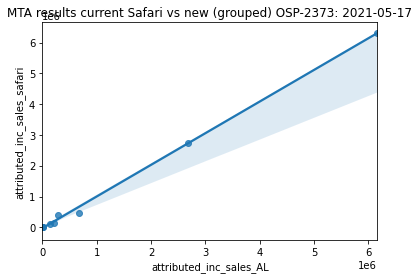

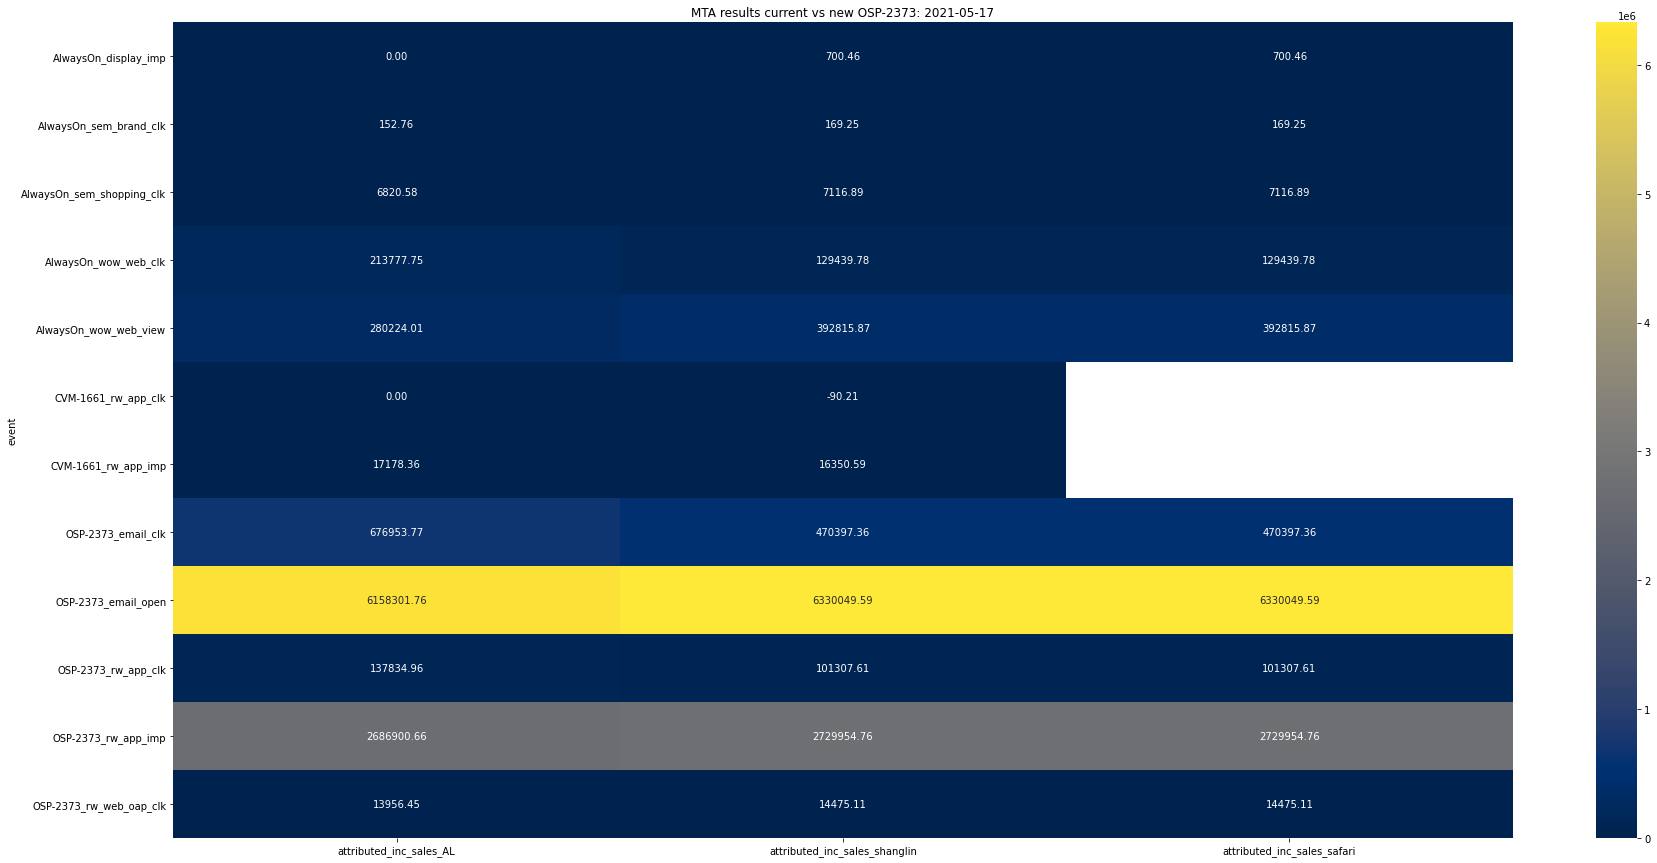

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-05-17 ... end of fw is 2021-05-23
	FB scaling ratio is (for missing slice of pie) 0.08569032964560988
	FB attribution ratio is 0.07892704513042946
	non-FB attribution ratio is 0.9210729548695706
	fb inc sales for OSP-2373 increased by 1.3230095487104672e-11
	touchpoint count increased by 516766
	exported dacamp_prod_mc_final_crn_w_fb to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-05-17_OSP-2373`


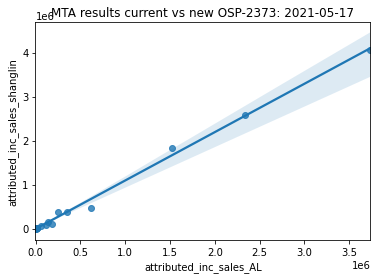

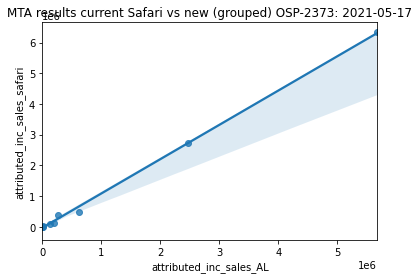

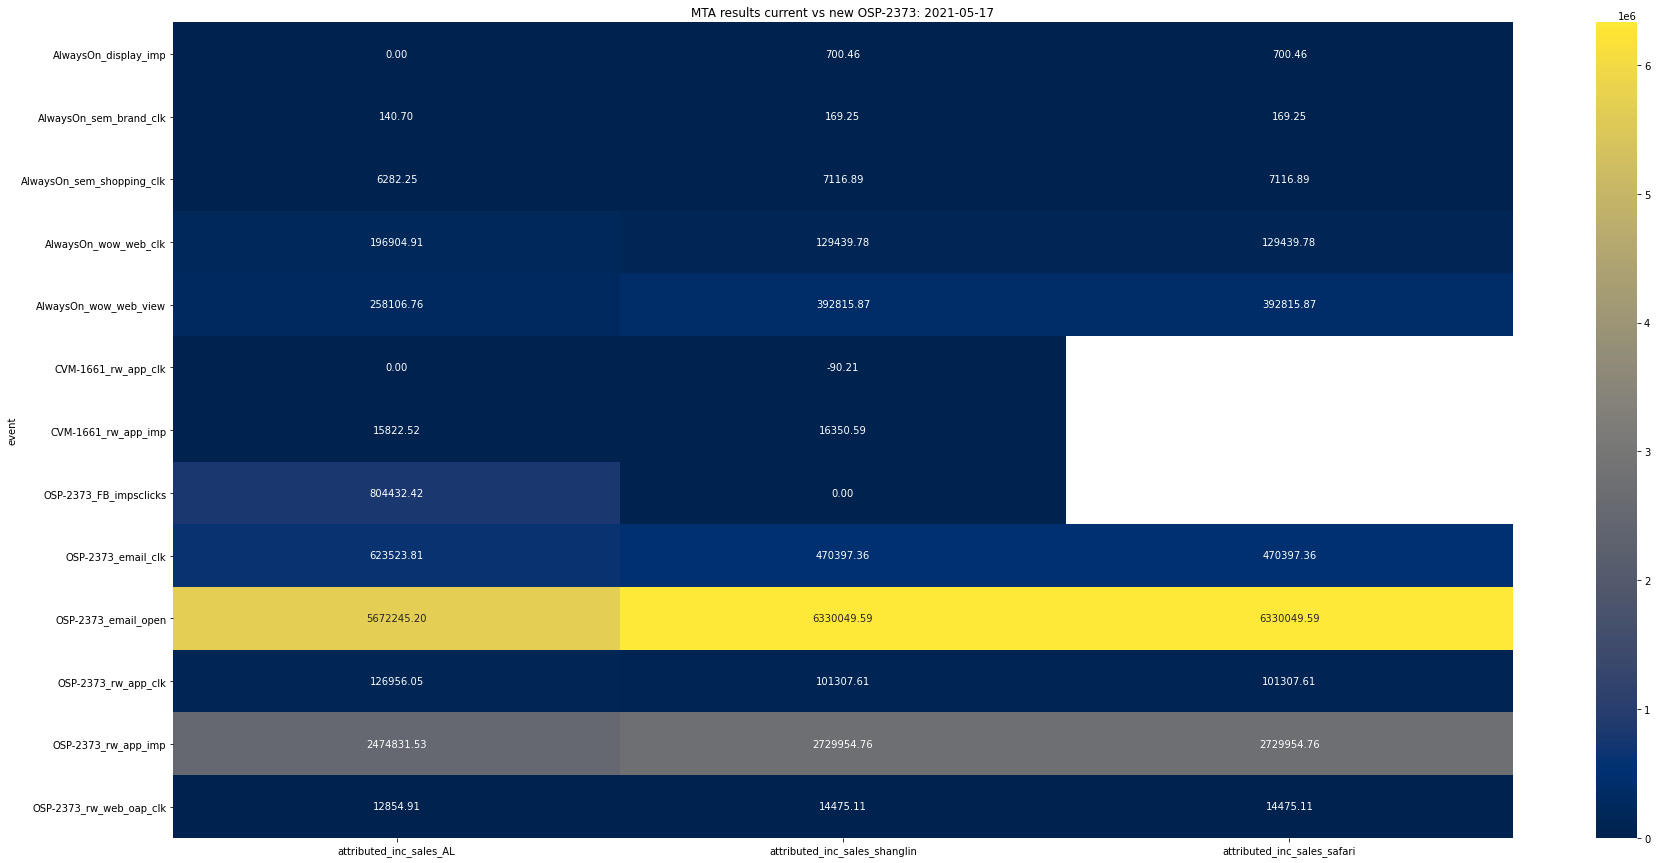

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_display_imp                   0.000000                    0.001584   
AlwaysOn_sem_brand_clk                 0.000494                    0.004002   
AlwaysOn_sem_shopping_clk              0.002072                    0.007172   
AlwaysOn_wow_web_clk                   0.062024                    0.174640   
AlwaysOn_wow_web_view                  0.052102                    0.303173   
CVM-1661_rw_app_clk                    0.000000                    0.001358   
CVM-1661_rw_app_imp                    0.010187                    0.016613   
OSP-2373_FB_impsclicks                -2.000000                    0.000000   
OSP-2373_email_clk                     0.207510                    0.224638   
OSP-2373_email_open                    0.231351                    0.417231   
OSP-2373_rw_app_clk                    0.080040                    0.130170   
OSP-2373_rw_app_imp                    0.351760                    0.703018   
OSP-2373_rw_web_oap_clk                0.002360                    0.016386   
Total                                 -1.000099                    1.999985   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_display_imp                  0.000000e+00   
AlwaysOn_sem_brand_clk                1.407017e+02   
AlwaysOn_sem_shopping_clk             6.282254e+03   
AlwaysOn_wow_web_clk                  1.969049e+05   
AlwaysOn_wow_web_view                 2.581068e+05   
CVM-1661_rw_app_clk                   0.000000e+00   
CVM-1661_rw_app_imp                   1.582252e+04   
OSP-2373_FB_impsclicks                8.044324e+05   
OSP-2373_email_clk                    6.235238e+05   
OSP-2373_email_open                   5.672245e+06   
OSP-2373_rw_app_clk                   1.269561e+05   
OSP-2373_rw_app_imp                   2.474832e+06   
OSP-2373_rw_web_oap_clk               1.285491e+04   
Total                                 1.019210e+07   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_display_imp                        7.004588e+02   
AlwaysOn_sem_brand_clk                      1.692540e+02   
AlwaysOn_sem_shopping_clk                   7.116890e+03   
AlwaysOn_wow_web_clk                        1.294398e+05   
AlwaysOn_wow_web_view                       3.928159e+05   
CVM-1661_rw_app_clk                        -9.021072e+01   
CVM-1661_rw_app_imp                         1.635059e+04   
OSP-2373_FB_impsclicks                      0.000000e+00   
OSP-2373_email_clk                          4.703974e+05   
OSP-2373_email_open                         6.330050e+06   
OSP-2373_rw_app_clk                         1.013076e+05   
OSP-2373_rw_app_imp                         2.729955e+06   
OSP-2373_rw_web_oap_clk                     1.447511e+04   
Total                                       1.019269e+07   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_display_imp                      7.004588e+02  
AlwaysOn_sem_brand_clk                    1.692540e+02  
AlwaysOn_sem_shopping_clk                 7.116890e+03  
AlwaysOn_wow_web_clk                      1.294398e+05  
AlwaysOn_wow_web_view                     3.928159e+05  
CVM-1661_rw_app_clk                                NaN  
CVM-1661_rw_app_imp                                NaN  
OSP-2373_FB_impsclicks                             NaN  
OSP-2373_email_clk                        4.703974e+05  
OSP-2373_email_open                       6.330050e+06  
OSP-2373_rw_app_clk                       1.013076e+05  
OSP-2373_rw_app_imp                       2.729955e+06  
OSP-2373_rw_web_oap_clk                   1.447511e+04  
Total                                     1.017643e+07

In [74]:
run_downstream_process(fpath_results="01_results/res_w_fb_weighted_2_OSP-2373_2021-05-17_2021-05-23_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-05-17",
                       safari_run_date="2021-05-25",
                       create_dacamp_prod_mc_final=False,
                       have_historical_marketable_crn=True,                       
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_w_fb_weighted")[0]

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_2021-05-10_OSP-2373`
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-05-10_OSP-2373`
>>> Step 3: Compare results to BAU run


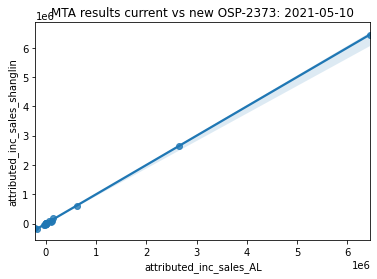

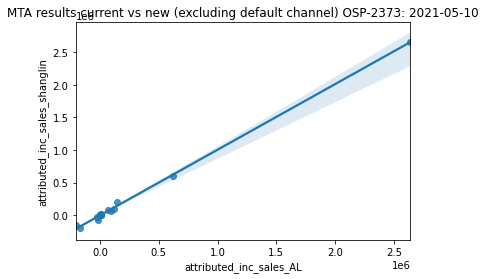

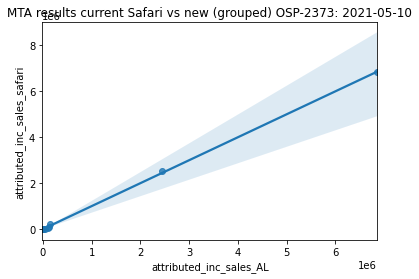

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-05-10 ... end of fw is 2021-05-16
	FB scaling ratio is (for missing slice of pie) 0.09223168051144665
	FB attribution ratio is 0.08444333025412555
	non-FB attribution ratio is 0.9155566697458744
	fb inc sales for OSP-2373 increased by 4.966825214025582e-12
	touchpoint count increased by 484482
	exported dacamp_prod_mc_final_crn_w_fb to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-05-10_OSP-2373`


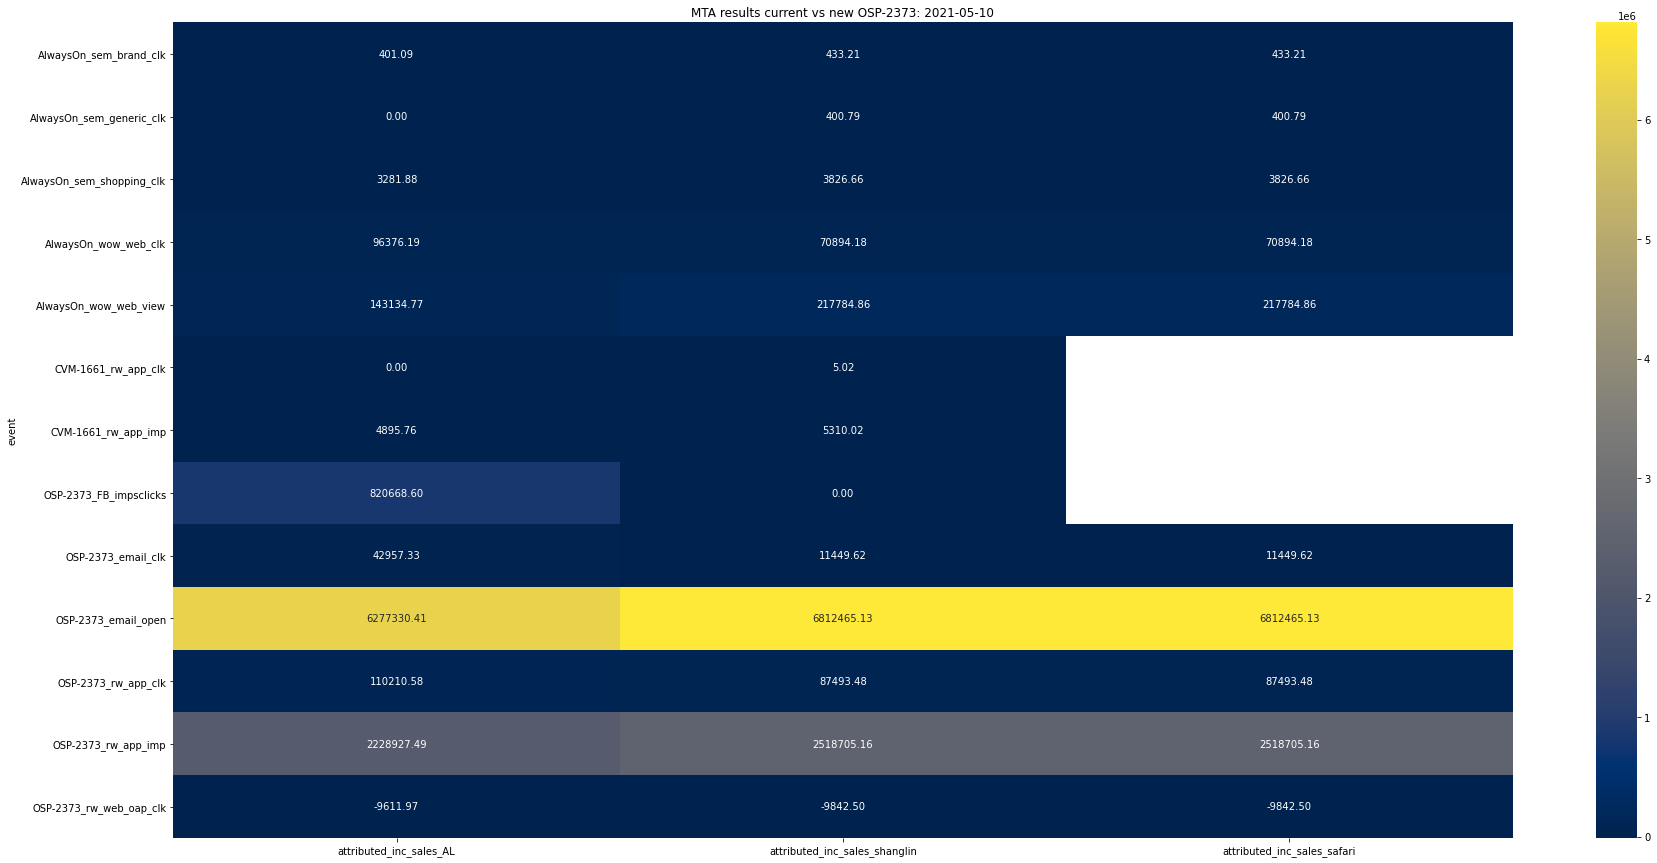

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_sem_brand_clk                 0.000763                    0.002866   
AlwaysOn_sem_generic_clk               0.000000                    0.001657   
AlwaysOn_sem_shopping_clk              0.004311                    0.027606   
AlwaysOn_wow_web_clk                   0.069263                    0.136680   
AlwaysOn_wow_web_view                  0.070753                    0.262769   
CVM-1661_rw_app_clk                    0.000000                    0.000968   
CVM-1661_rw_app_imp                    0.003385                    0.005648   
OSP-2373_FB_impsclicks                -2.000000                    0.000000   
OSP-2373_email_clk                     0.040368                    0.309087   
OSP-2373_email_open                    0.106187                    0.496630   
OSP-2373_rw_app_clk                    0.126555                    0.131773   
OSP-2373_rw_app_imp                    0.576351                    0.605252   
OSP-2373_rw_web_oap_clk                0.002064                    0.019050   
Total                                 -1.000000                    1.999986   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_sem_brand_clk                4.010867e+02   
AlwaysOn_sem_generic_clk              0.000000e+00   
AlwaysOn_sem_shopping_clk             3.281881e+03   
AlwaysOn_wow_web_clk                  9.637619e+04   
AlwaysOn_wow_web_view                 1.431348e+05   
CVM-1661_rw_app_clk                   0.000000e+00   
CVM-1661_rw_app_imp                   4.895757e+03   
OSP-2373_FB_impsclicks                8.206686e+05   
OSP-2373_email_clk                    4.295733e+04   
OSP-2373_email_open                   6.277330e+06   
OSP-2373_rw_app_clk                   1.102106e+05   
OSP-2373_rw_app_imp                   2.228927e+06   
OSP-2373_rw_web_oap_clk              -9.611974e+03   
Total                                 9.718572e+06   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_sem_brand_clk                      4.332057e+02   
AlwaysOn_sem_generic_clk                    4.007940e+02   
AlwaysOn_sem_shopping_clk                   3.826662e+03   
AlwaysOn_wow_web_clk                        7.089418e+04   
AlwaysOn_wow_web_view                       2.177849e+05   
CVM-1661_rw_app_clk                         5.022599e+00   
CVM-1661_rw_app_imp                         5.310020e+03   
OSP-2373_FB_impsclicks                      0.000000e+00   
OSP-2373_email_clk                          1.144962e+04   
OSP-2373_email_open                         6.812465e+06   
OSP-2373_rw_app_clk                         8.749348e+04   
OSP-2373_rw_app_imp                         2.518705e+06   
OSP-2373_rw_web_oap_clk                    -9.842502e+03   
Total                                       9.718926e+06   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_sem_brand_clk                    4.332057e+02  
AlwaysOn_sem_generic_clk                  4.007940e+02  
AlwaysOn_sem_shopping_clk                 3.826662e+03  
AlwaysOn_wow_web_clk                      7.089418e+04  
AlwaysOn_wow_web_view                     2.177849e+05  
CVM-1661_rw_app_clk                                NaN  
CVM-1661_rw_app_imp                                NaN  
OSP-2373_FB_impsclicks                             NaN  
OSP-2373_email_clk                        1.144962e+04  
OSP-2373_email_open                       6.812465e+06  
OSP-2373_rw_app_clk                       8.749348e+04  
OSP-2373_rw_app_imp                       2.518705e+06  
OSP-2373_rw_web_oap_clk                  -9.842502e+03  
Total                                     9.713611e+06

In [75]:
run_downstream_process(fpath_results="01_results/res_w_fb_weighted_2_OSP-2373_2021-05-10_2021-05-16_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-05-10",
                       safari_run_date="2021-05-18",
                       create_dacamp_prod_mc_final=False,
                       have_historical_marketable_crn=True,                       
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_w_fb_weighted")[0]

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_2021-05-03_OSP-2373`
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-05-03_OSP-2373`
>>> Step 3: Compare results to BAU run


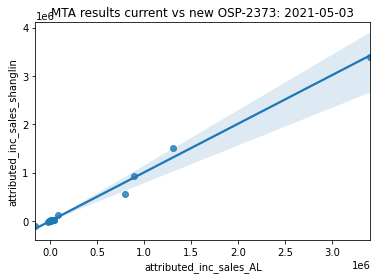

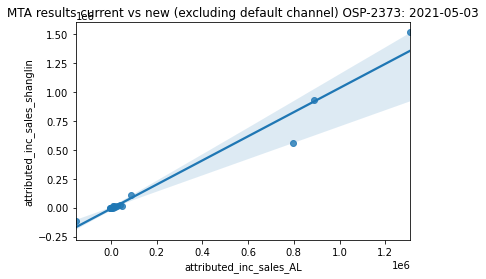

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-05-03 ... end of fw is 2021-05-09
	FB scaling ratio is (for missing slice of pie) 0.0721347631435228
	FB attribution ratio is 0.06728143291615886
	non-FB attribution ratio is 0.9327185670838412
	fb inc sales for OSP-2373 increased by 1.0285913866430121e-11
	touchpoint count increased by 461812
	exported dacamp_prod_mc_final_crn_w_fb to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-05-03_OSP-2373`


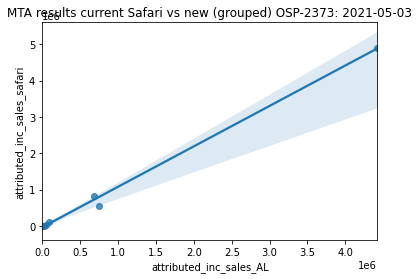

(                           channel_prob_norm_AL  channel_prob_norm_shanglin  \
 event                                                                         
 AlwaysOn_sem_shopping_clk              0.000872                    0.012386   
 AlwaysOn_video_imp                     0.000733                    0.000000   
 AlwaysOn_wow_web_clk                   0.038901                    0.051573   
 AlwaysOn_wow_web_view                  0.044085                    0.116879   
 CVM-1661_rw_app_clk                    0.000000                    0.000757   
 CVM-1661_rw_app_imp                    0.001368                    0.007662   
 OSP-2373_FB_impsclicks                -2.000000                    0.000000   
 OSP-2373_email_clk                     0.309518                    0.488234   
 OSP-2373_email_open                    0.279719                    0.776464   
 OSP-2373_rw_app_clk                    0.053348                    0.067824   
 OSP-2373_rw_app_imp                    

In [76]:
run_downstream_process(fpath_results="01_results/res_w_fb_weighted_2_OSP-2373_2021-05-03_2021-05-09_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-05-03",
                       safari_run_date="2021-05-11",
                       create_dacamp_prod_mc_final=False,
                       have_historical_marketable_crn=True,                       
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_w_fb_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_2021-04-26_OSP-2373`
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-04-26_OSP-2373`
>>> Step 3: Compare results to BAU run


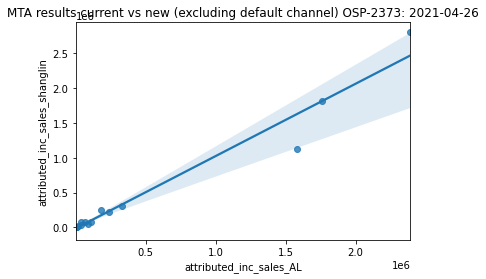

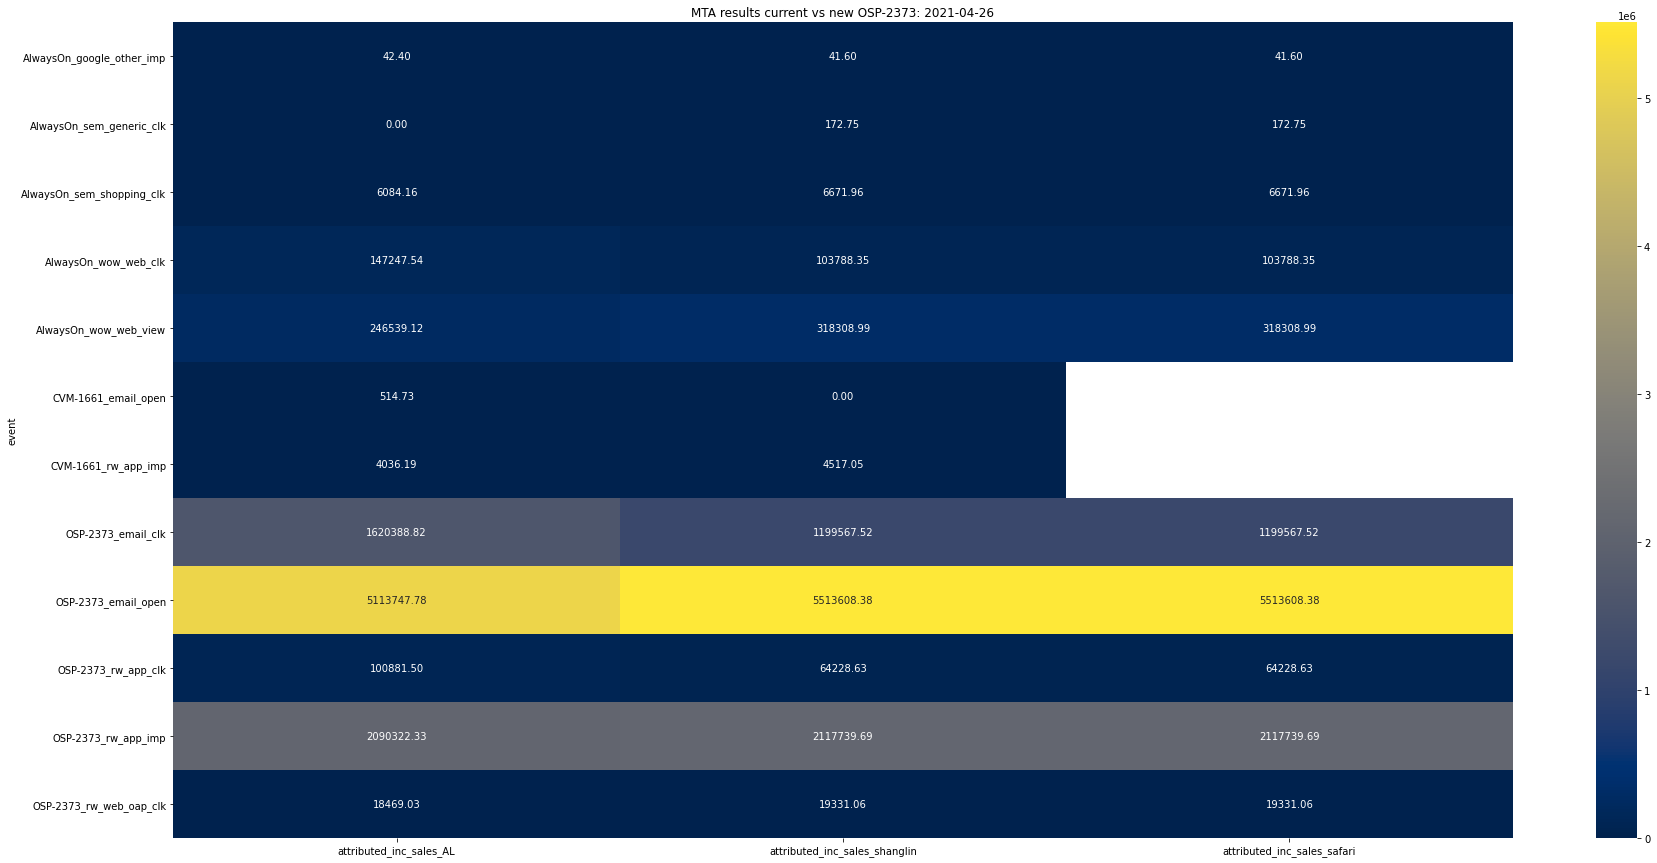

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-04-26 ... end of fw is 2021-05-02
	FB scaling ratio is (for missing slice of pie) 0.005202618406286034
	FB attribution ratio is 0.0051756912596732044
	non-FB attribution ratio is 0.9948243087403268
	fb inc sales for OSP-2373 increased by 2.120818861084416e-12
	touchpoint count increased by 481505
	exported dacamp_prod_mc_final_crn_w_fb to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-04-26_OSP-2373`


(                           channel_prob_norm_AL  channel_prob_norm_shanglin  \
 event                                                                         
 AlwaysOn_google_other_imp              0.000205                    0.001178   
 AlwaysOn_sem_generic_clk               0.000000                    0.001056   
 AlwaysOn_sem_shopping_clk              0.001550                    0.019191   
 AlwaysOn_wow_web_clk                   0.029462                    0.084996   
 AlwaysOn_wow_web_view                  0.029815                    0.151728   
 CVM-1661_email_open                    0.000201                    0.000000   
 CVM-1661_rw_app_imp                    0.003259                    0.013294   
 OSP-2373_FB_impsclicks                -2.000000                    0.000000   
 OSP-2373_email_clk                     0.328421                    0.440363   
 OSP-2373_email_open                    0.285754                    0.725882   
 OSP-2373_rw_app_clk                    

In [86]:
run_downstream_process(fpath_results="01_results/res_w_fb_weighted_2_OSP-2373_2021-04-26_2021-05-02_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-04-26",
                       safari_run_date="2021-05-04",
                       create_dacamp_prod_mc_final=False,
                       have_historical_marketable_crn=True,                       
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_w_fb_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_2021-04-19_OSP-2373`
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-04-19_OSP-2373`
>>> Step 3: Compare results to BAU run


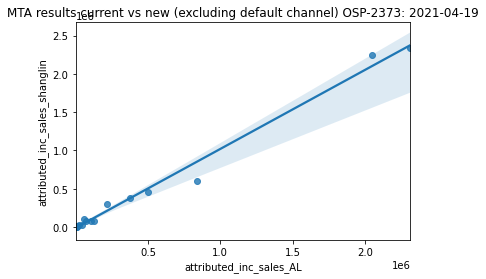

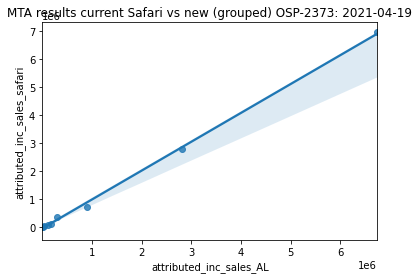

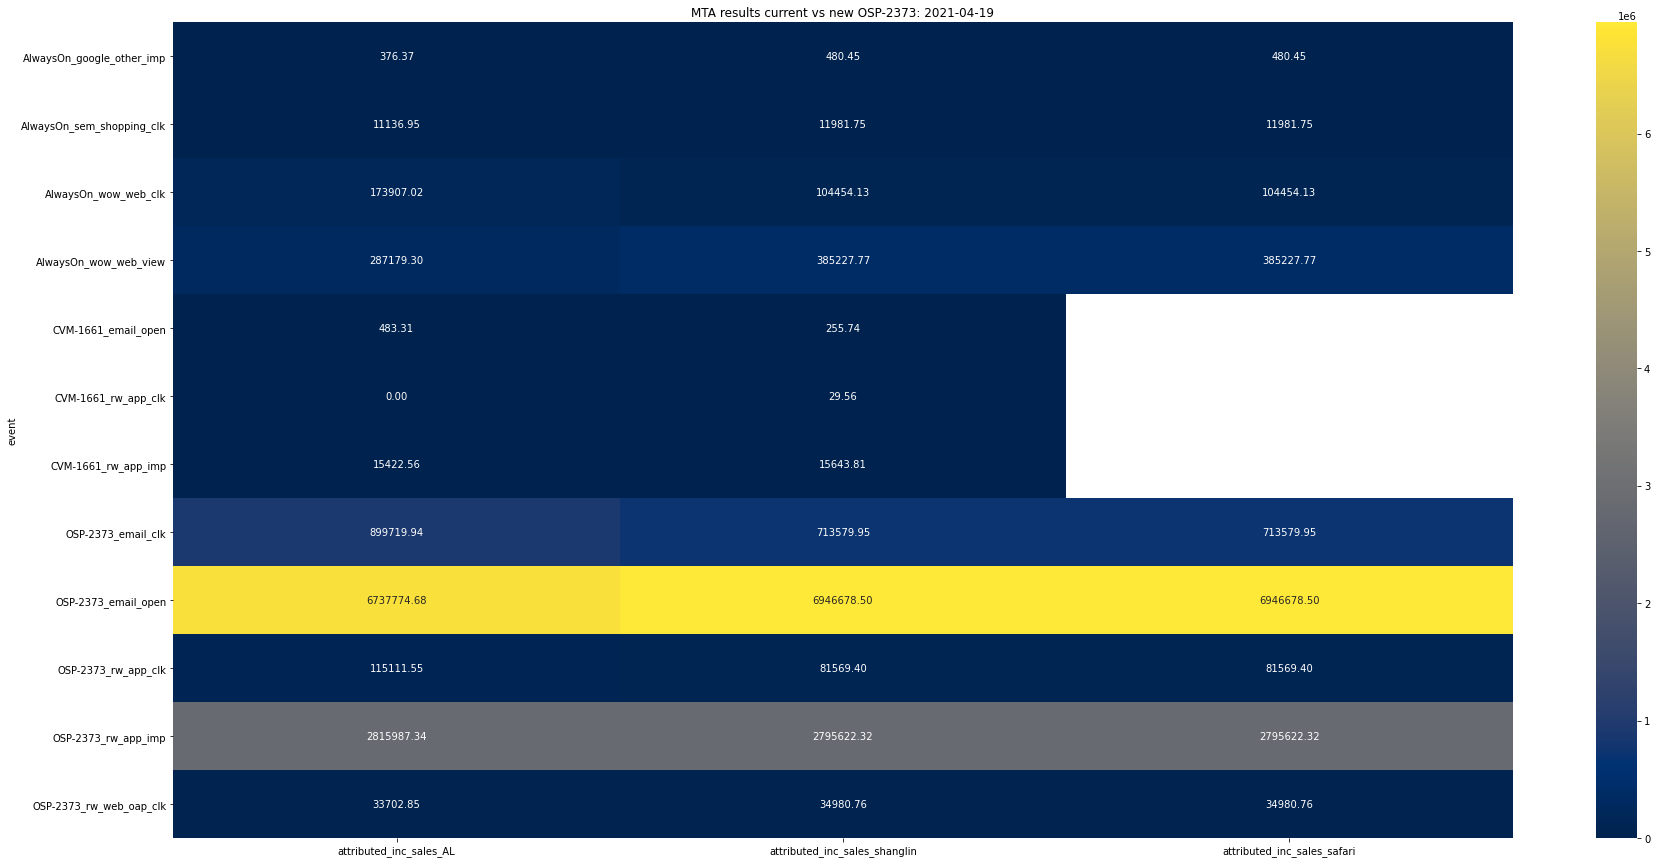

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-04-19 ... end of fw is 2021-04-25
	FB scaling ratio is (for missing slice of pie) 0.04736980147840679
	FB attribution ratio is 0.04522738903827694
	non-FB attribution ratio is 0.9547726109617231
	fb inc sales for OSP-2373 increased by -4.705819987283554e-13
	touchpoint count increased by 437820
	exported dacamp_prod_mc_final_crn_w_fb to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-04-19_OSP-2373`


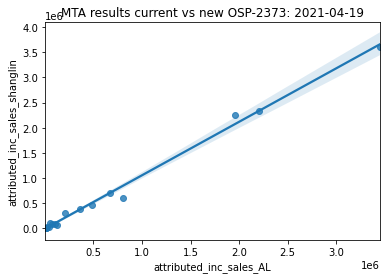

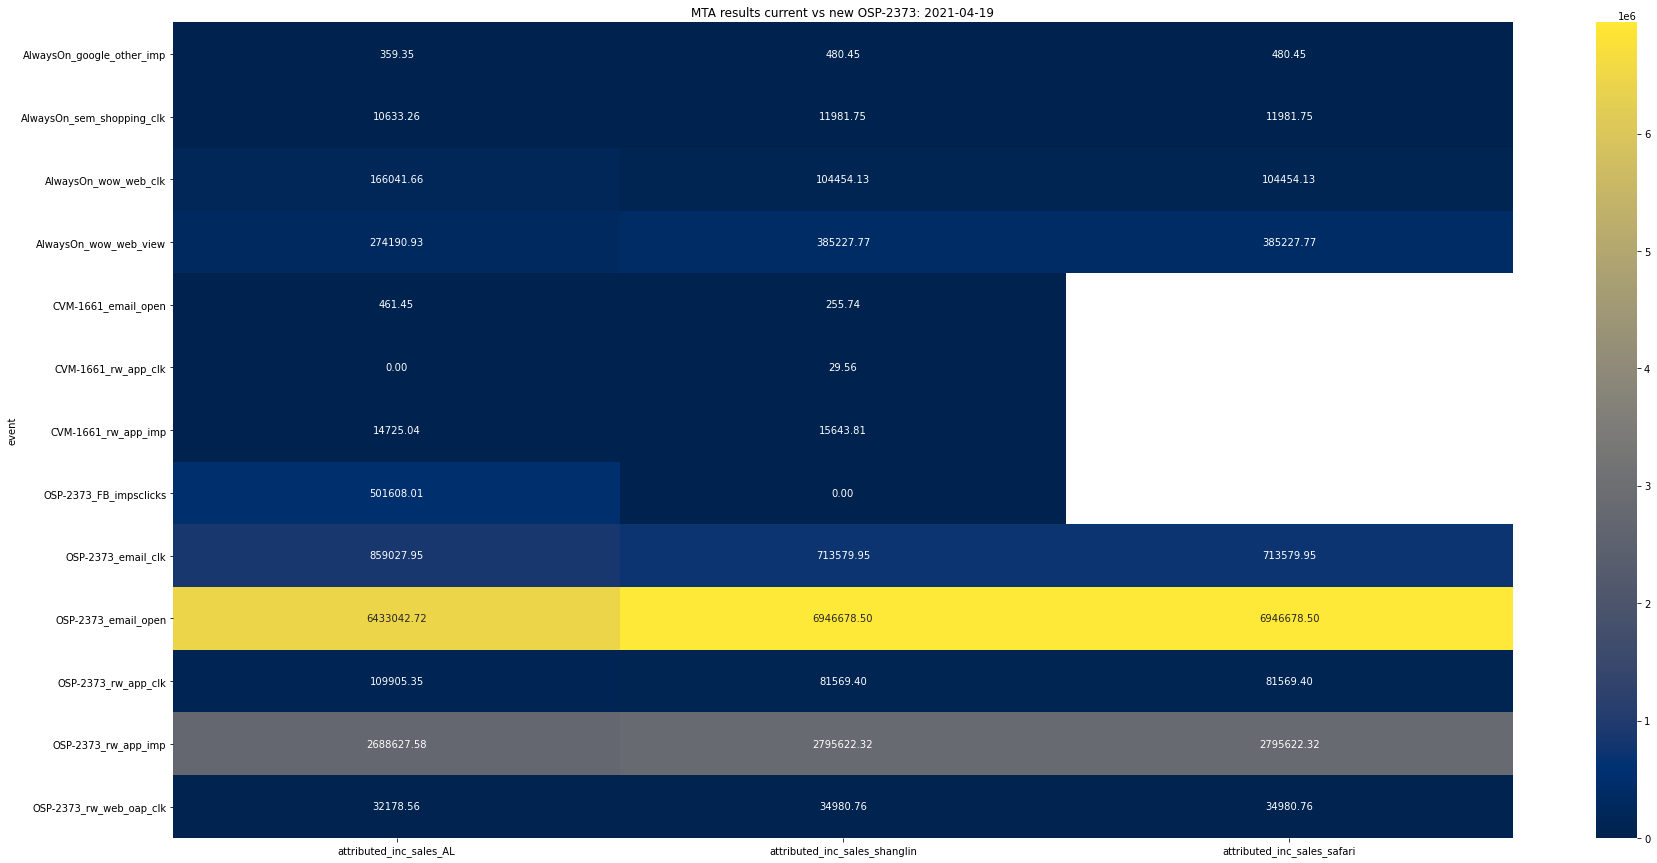

(                           channel_prob_norm_AL  channel_prob_norm_shanglin  \
 event                                                                         
 AlwaysOn_google_other_imp              0.000181                    0.001163   
 AlwaysOn_sem_shopping_clk              0.001925                    0.014021   
 AlwaysOn_wow_web_clk                   0.047471                    0.085955   
 AlwaysOn_wow_web_view                  0.040666                    0.176636   
 CVM-1661_email_open                    0.000407                    0.001181   
 CVM-1661_rw_app_clk                    0.000000                    0.003874   
 CVM-1661_rw_app_imp                    0.009495                    0.018404   
 OSP-2373_FB_impsclicks                -2.000000                    0.000000   
 OSP-2373_email_clk                     0.228884                    0.374050   
 OSP-2373_email_open                    0.264335                    0.696860   
 OSP-2373_rw_app_clk                    

In [77]:
run_downstream_process(fpath_results="01_results/res_w_fb_weighted_2_OSP-2373_2021-04-19_2021-04-25_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-04-19",
                       safari_run_date="2021-04-27",
                       create_dacamp_prod_mc_final=False,
                       have_historical_marketable_crn=True,                       
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_w_fb_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_2021-04-12_OSP-2373`
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-04-12_OSP-2373`
>>> Step 3: Compare results to BAU run


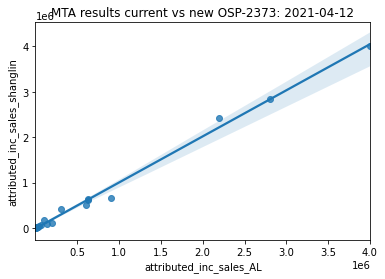

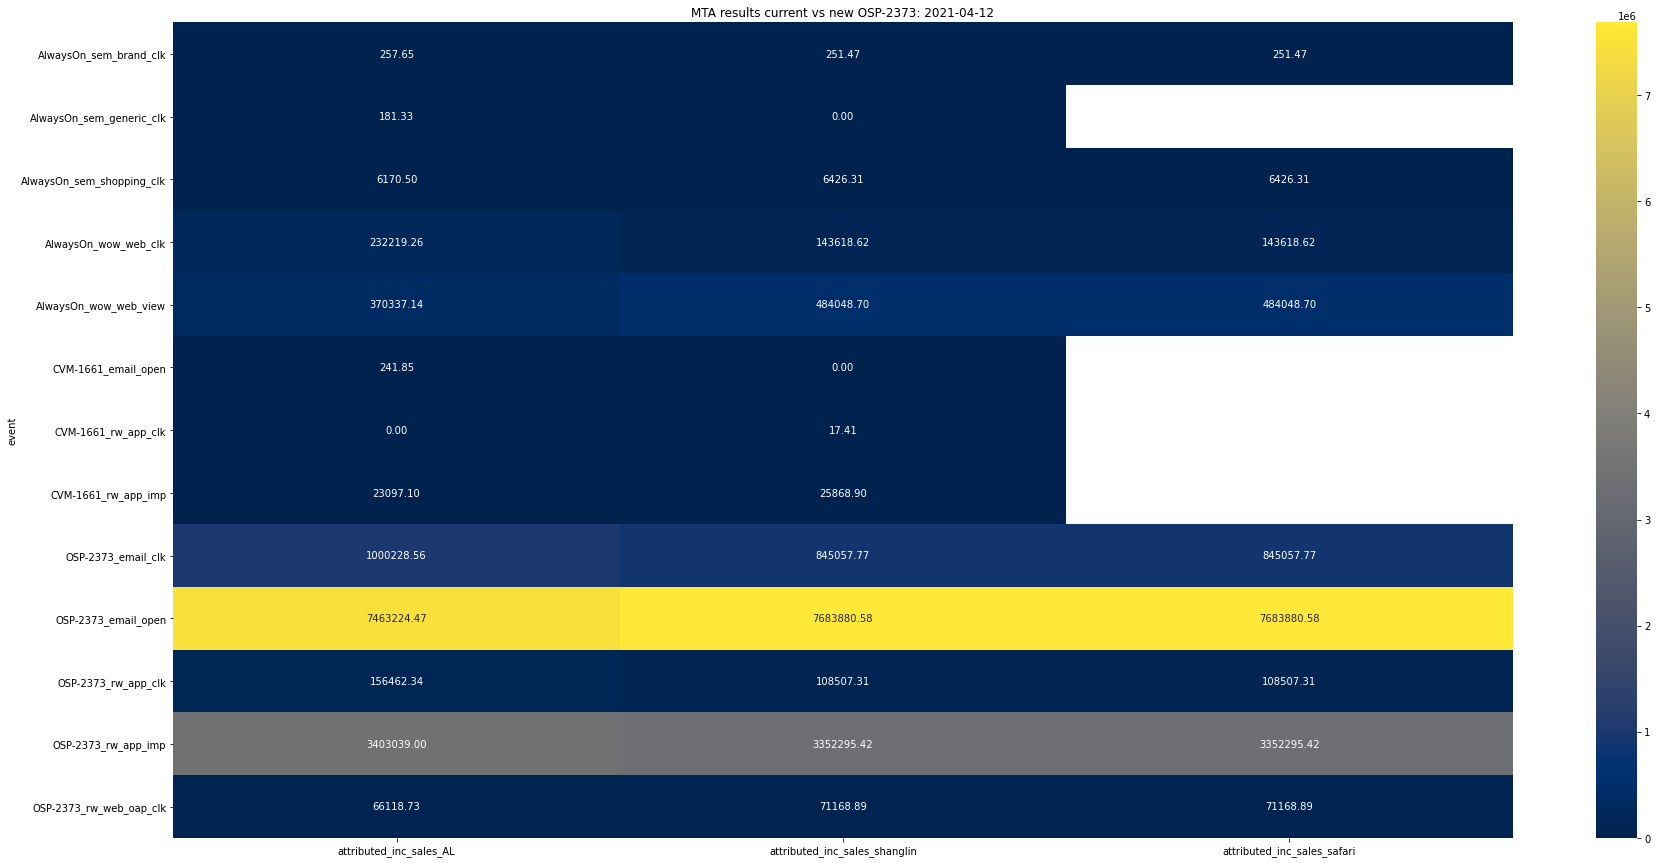

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-04-12 ... end of fw is 2021-04-18
	FB scaling ratio is (for missing slice of pie) 0.08305185528270402
	FB attribution ratio is 0.0766831753046814
	non-FB attribution ratio is 0.9233168246953186
	fb inc sales for OSP-2373 increased by 6.552857199483472e-12
	touchpoint count increased by 465460
	exported dacamp_prod_mc_final_crn_w_fb to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-04-12_OSP-2373`


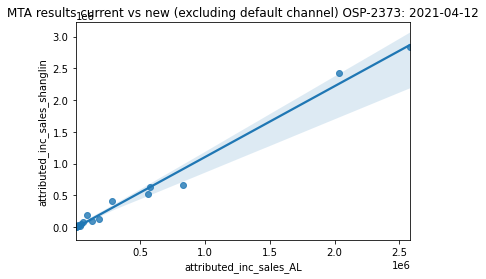

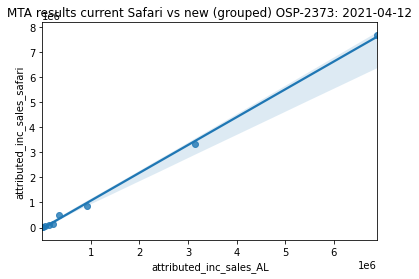

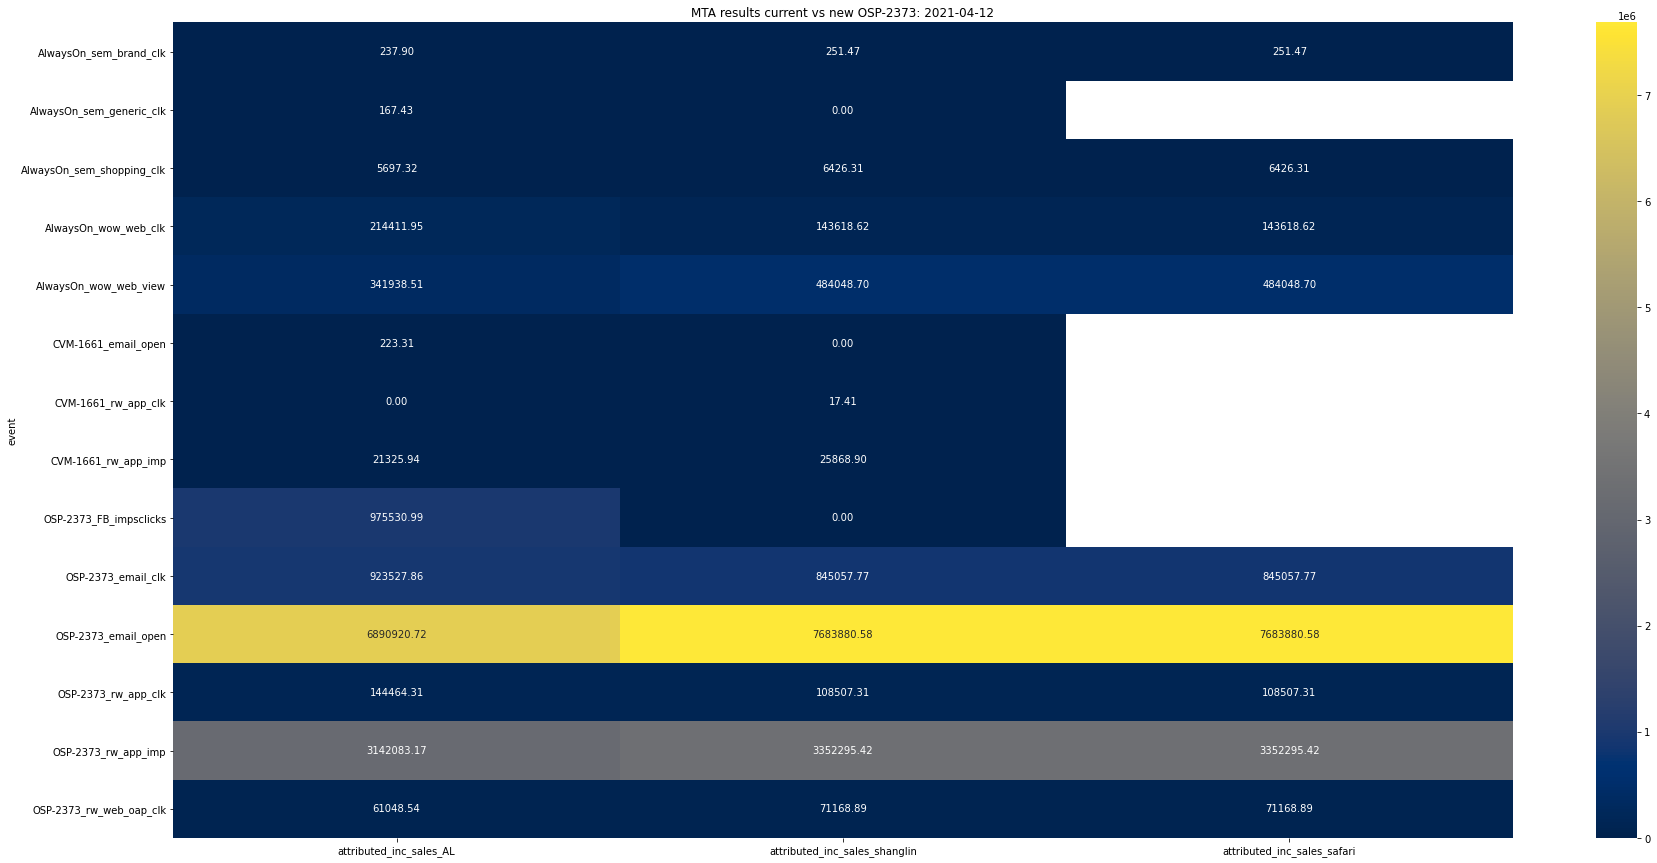

(                           channel_prob_norm_AL  channel_prob_norm_shanglin  \
 event                                                                         
 AlwaysOn_sem_brand_clk                 0.000056                    0.001142   
 AlwaysOn_sem_generic_clk               0.000040                    0.000000   
 AlwaysOn_sem_shopping_clk              0.002015                    0.007876   
 AlwaysOn_wow_web_clk                   0.048336                    0.070791   
 AlwaysOn_wow_web_view                  0.042951                    0.149902   
 CVM-1661_email_open                    0.000593                    0.000000   
 CVM-1661_rw_app_clk                    0.000000                    0.002358   
 CVM-1661_rw_app_imp                    0.012075                    0.025717   
 OSP-2373_FB_impsclicks                -2.000000                    0.000000   
 OSP-2373_email_clk                     0.212070                    0.417670   
 OSP-2373_email_open                    

In [78]:
run_downstream_process(fpath_results="01_results/res_w_fb_weighted_2_OSP-2373_2021-04-12_2021-04-18_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-04-12",
                       safari_run_date="2021-04-21",
                       create_dacamp_prod_mc_final=False,
                       have_historical_marketable_crn=True,                       
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_w_fb_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_2021-04-05_OSP-2373`
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-04-05_OSP-2373`
>>> Step 3: Compare results to BAU run


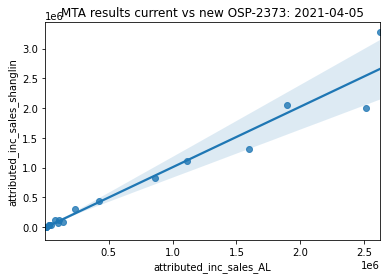

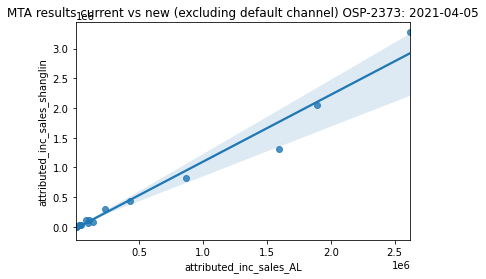

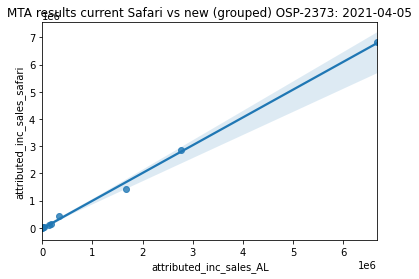

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-04-05 ... end of fw is 2021-04-11
	FB scaling ratio is (for missing slice of pie) 0.02843062919896291
	FB attribution ratio is 0.02764467373079633
	non-FB attribution ratio is 0.9723553262692037
	fb inc sales for OSP-2373 increased by -5.493167793197089e-12
	touchpoint count increased by 444313
	exported dacamp_prod_mc_final_crn_w_fb to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-04-05_OSP-2373`


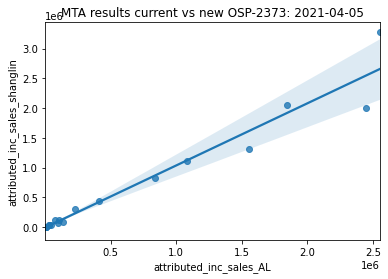

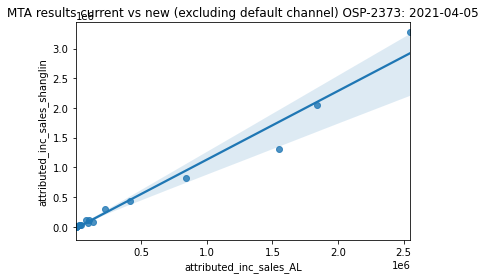

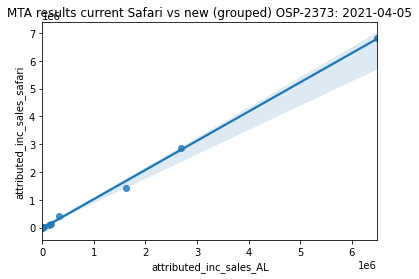

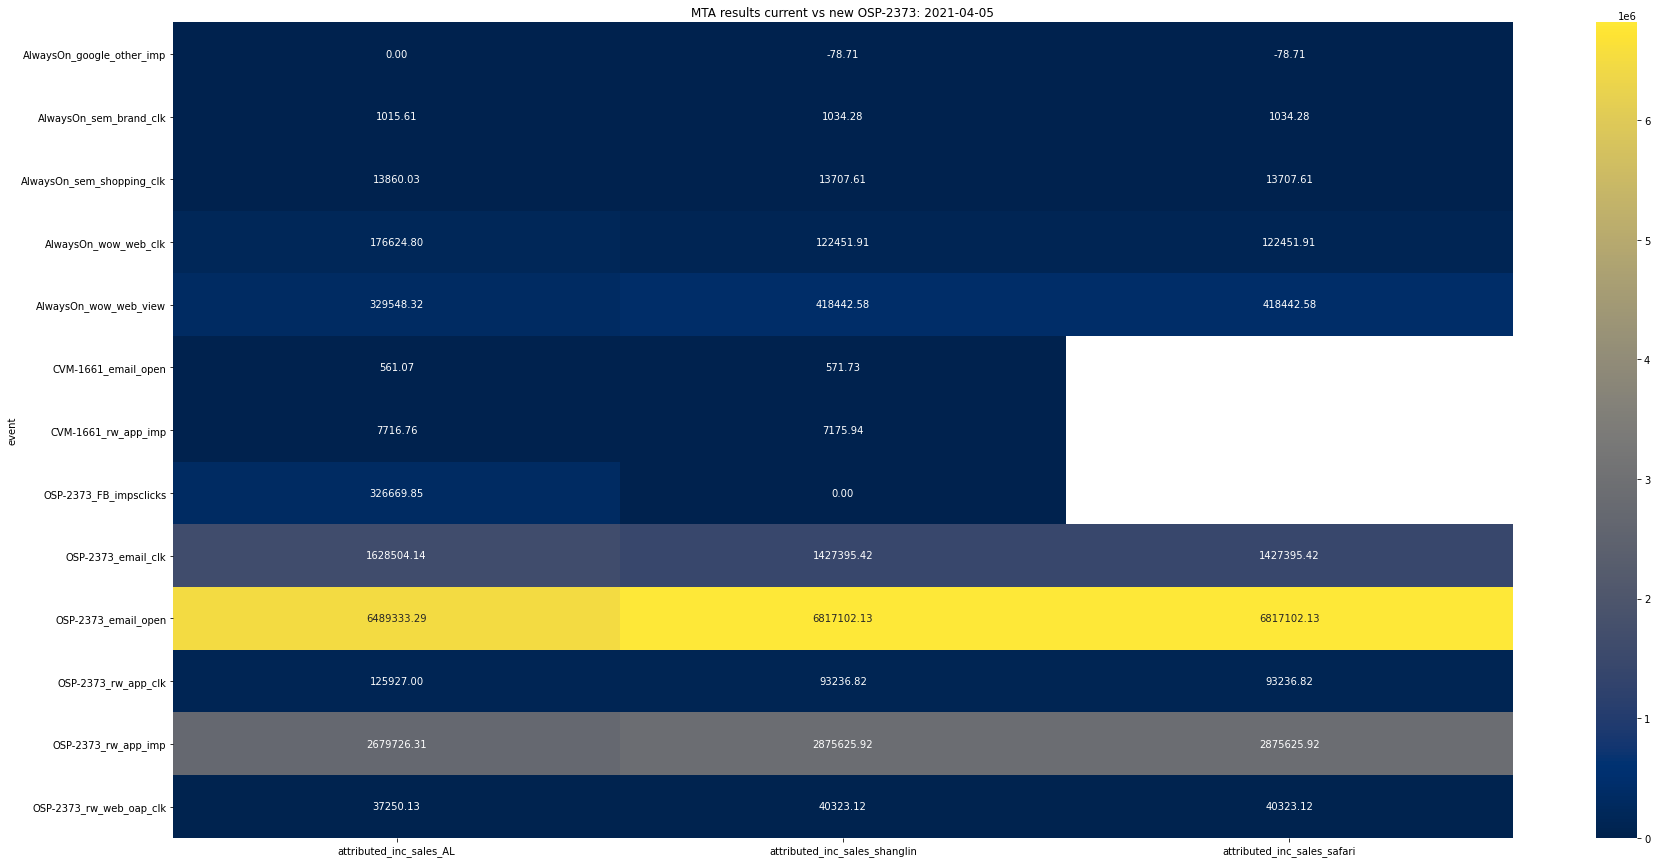

(                           channel_prob_norm_AL  channel_prob_norm_shanglin  \
 event                                                                         
 AlwaysOn_google_other_imp              0.000000                    0.001037   
 AlwaysOn_sem_brand_clk                 0.000401                    0.002505   
 AlwaysOn_sem_shopping_clk              0.001613                    0.010848   
 AlwaysOn_wow_web_clk                   0.035061                    0.089561   
 AlwaysOn_wow_web_view                  0.033229                    0.180016   
 CVM-1661_email_open                    0.000268                    0.001252   
 CVM-1661_rw_app_imp                    0.004864                    0.011670   
 OSP-2373_FB_impsclicks                -2.000000                    0.000000   
 OSP-2373_email_clk                     0.308665                    0.390702   
 OSP-2373_email_open                    0.290168                    0.681150   
 OSP-2373_rw_app_clk                    

In [79]:
run_downstream_process(fpath_results="01_results/res_w_fb_weighted_2_OSP-2373_2021-04-05_2021-04-11_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-04-05",
                       safari_run_date="2021-04-13",
                       create_dacamp_prod_mc_final=True,
                       have_historical_marketable_crn=False,
                       which_mc_crn_output="Weixing",
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_w_fb_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_2021-03-29_OSP-2373`
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-03-29_OSP-2373`
>>> Step 3: Compare results to BAU run


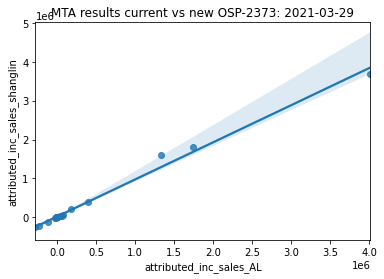

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-03-29 ... end of fw is 2021-04-04
	FB scaling ratio is (for missing slice of pie) 0.08304381278531035
	FB attribution ratio is 0.07667631891247595
	non-FB attribution ratio is 0.923323681087524
	fb inc sales for OSP-2373 increased by -5.236245543102638e-12
	touchpoint count increased by 517078
	exported dacamp_prod_mc_final_crn_w_fb to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-03-29_OSP-2373`


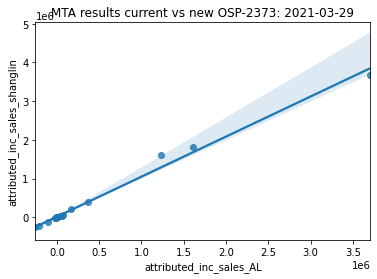

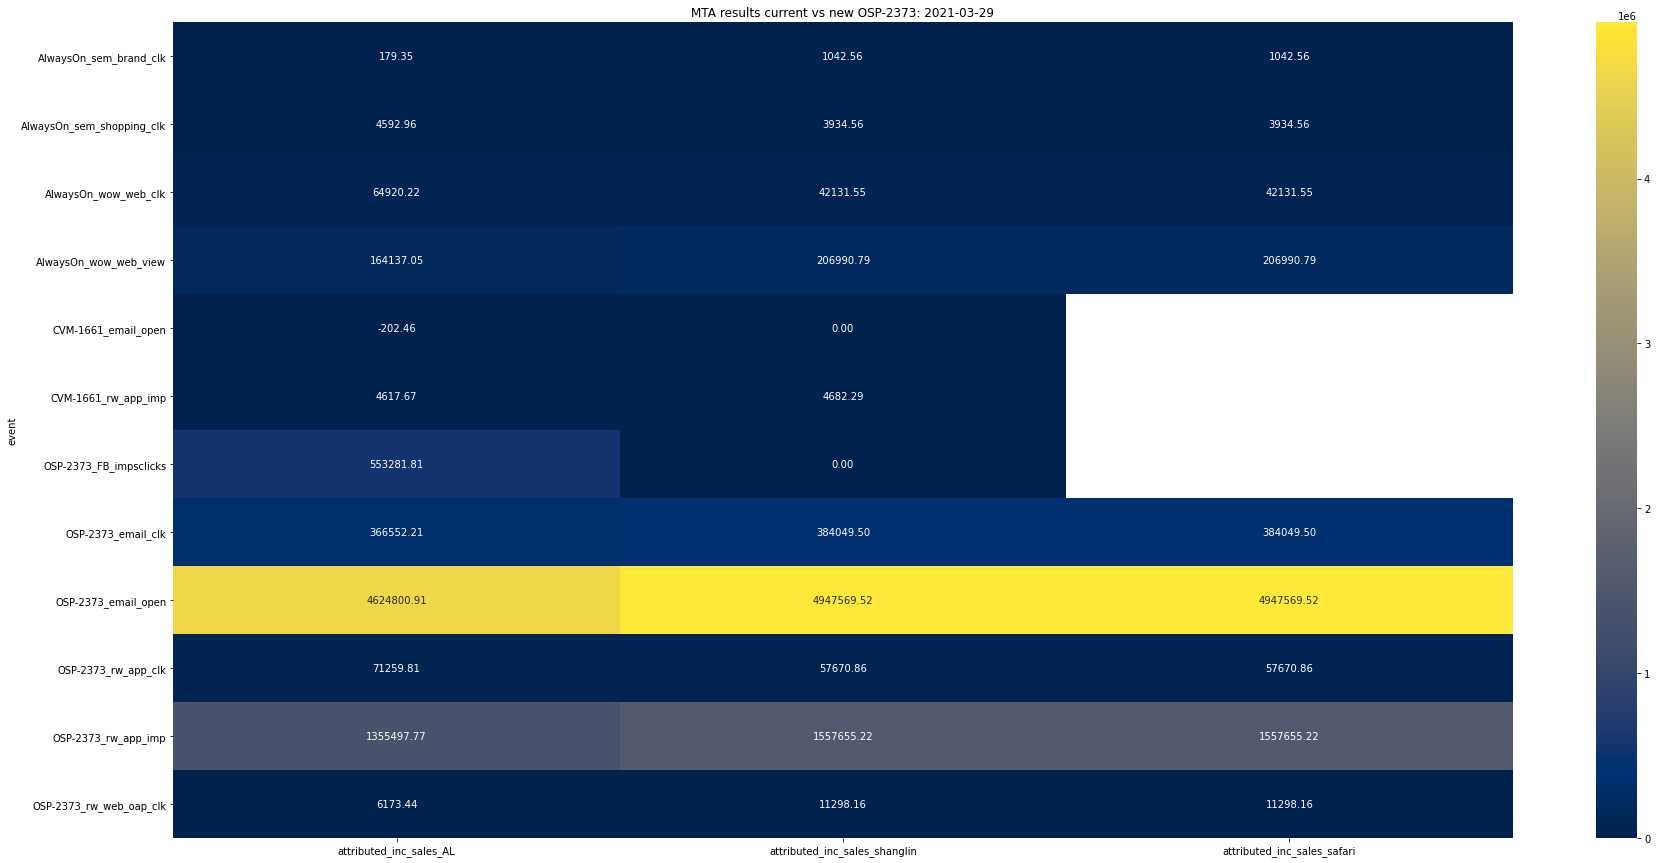

(                           channel_prob_norm_AL  channel_prob_norm_shanglin  \
 event                                                                         
 AlwaysOn_sem_brand_clk                 0.000250                    0.003324   
 AlwaysOn_sem_shopping_clk              0.003444                    0.014029   
 AlwaysOn_wow_web_clk                   0.053504                    0.079322   
 AlwaysOn_wow_web_view                  0.065129                    0.189427   
 CVM-1661_email_open                    0.000310                    0.000000   
 CVM-1661_rw_app_imp                    0.005966                    0.012382   
 OSP-2373_FB_impsclicks                -2.000000                    0.000000   
 OSP-2373_email_clk                     0.190780                    0.381090   
 OSP-2373_email_open                    0.241926                    0.648958   
 OSP-2373_rw_app_clk                    0.078422                    0.096452   
 OSP-2373_rw_app_imp                    

In [80]:
run_downstream_process(fpath_results="01_results/res_w_fb_weighted_2_OSP-2373_2021-03-29_2021-04-04_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-03-29",
                       safari_run_date="2021-04-08",
                       create_dacamp_prod_mc_final=True,
                       have_historical_marketable_crn=False,
                       which_mc_crn_output="Weixing",
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_w_fb_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_2021-03-22_OSP-2373`
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-03-22_OSP-2373`
>>> Step 3: Compare results to BAU run


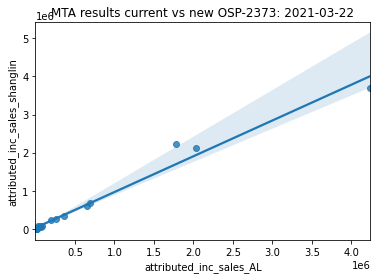

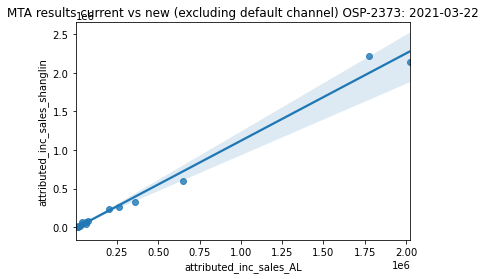

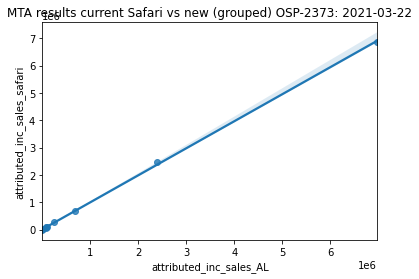

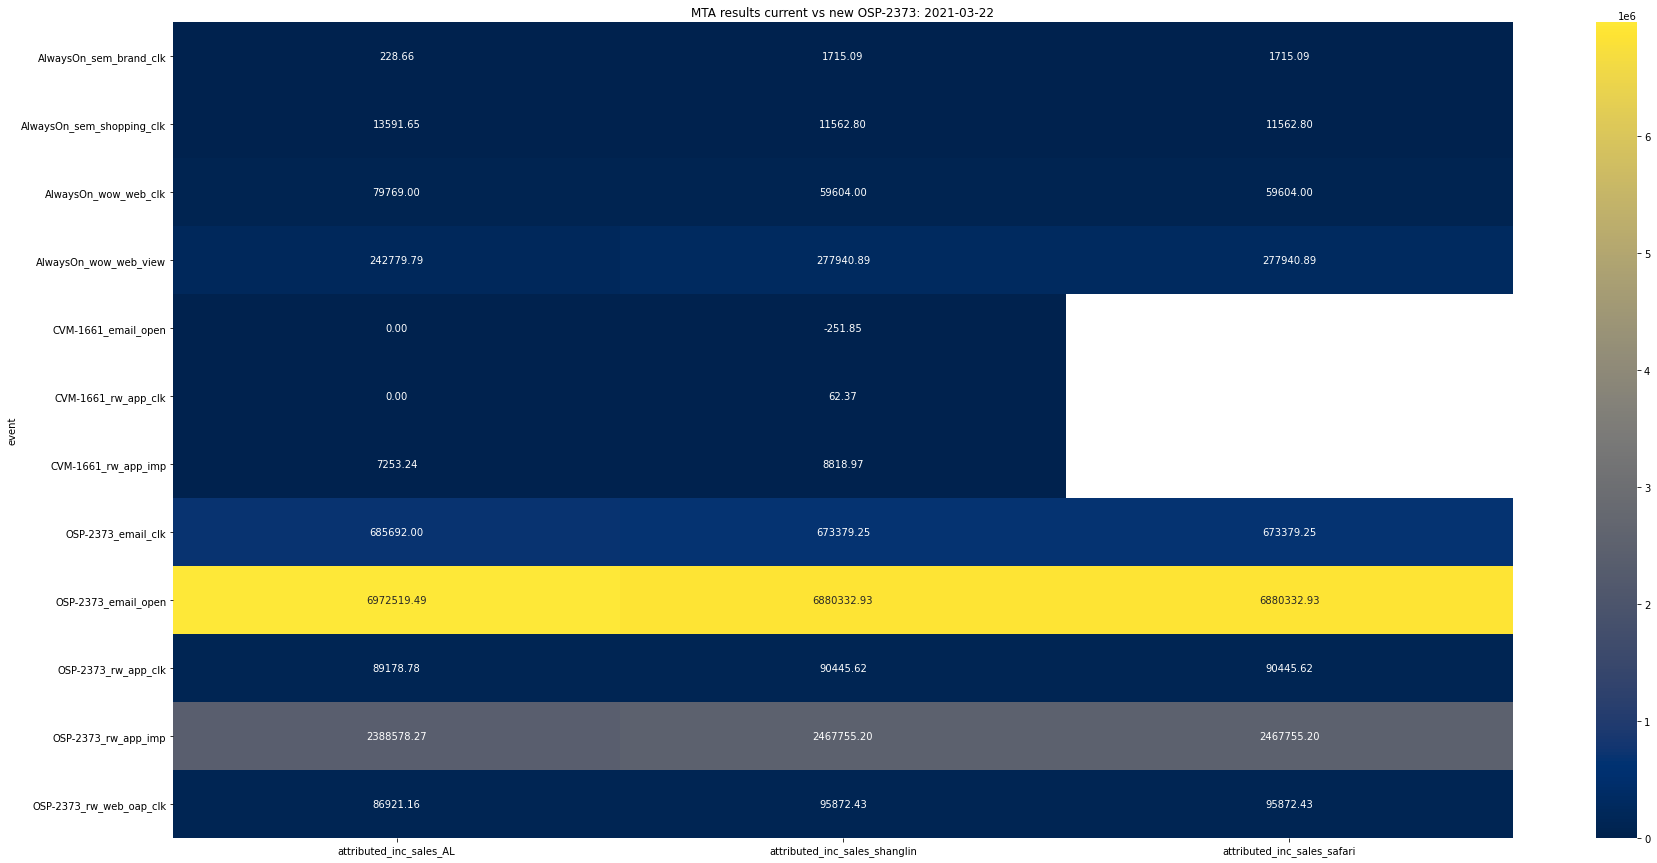

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-03-22 ... end of fw is 2021-03-28
	FB scaling ratio is (for missing slice of pie) 0.055825875508280734
	FB attribution ratio is 0.05287413086121405
	non-FB attribution ratio is 0.9471258691387859
	fb inc sales for OSP-2373 increased by 7.258781477749238e-12
	touchpoint count increased by 599224
	exported dacamp_prod_mc_final_crn_w_fb to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-03-22_OSP-2373`


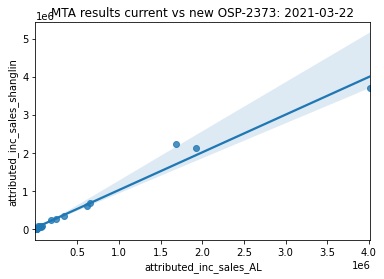

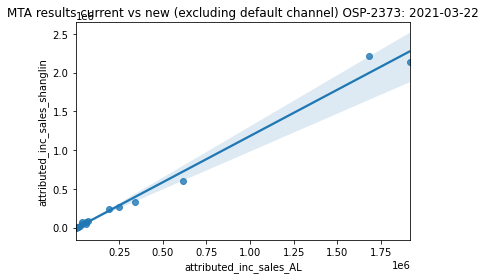

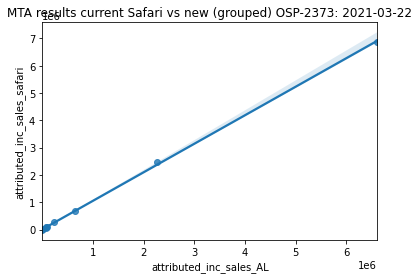

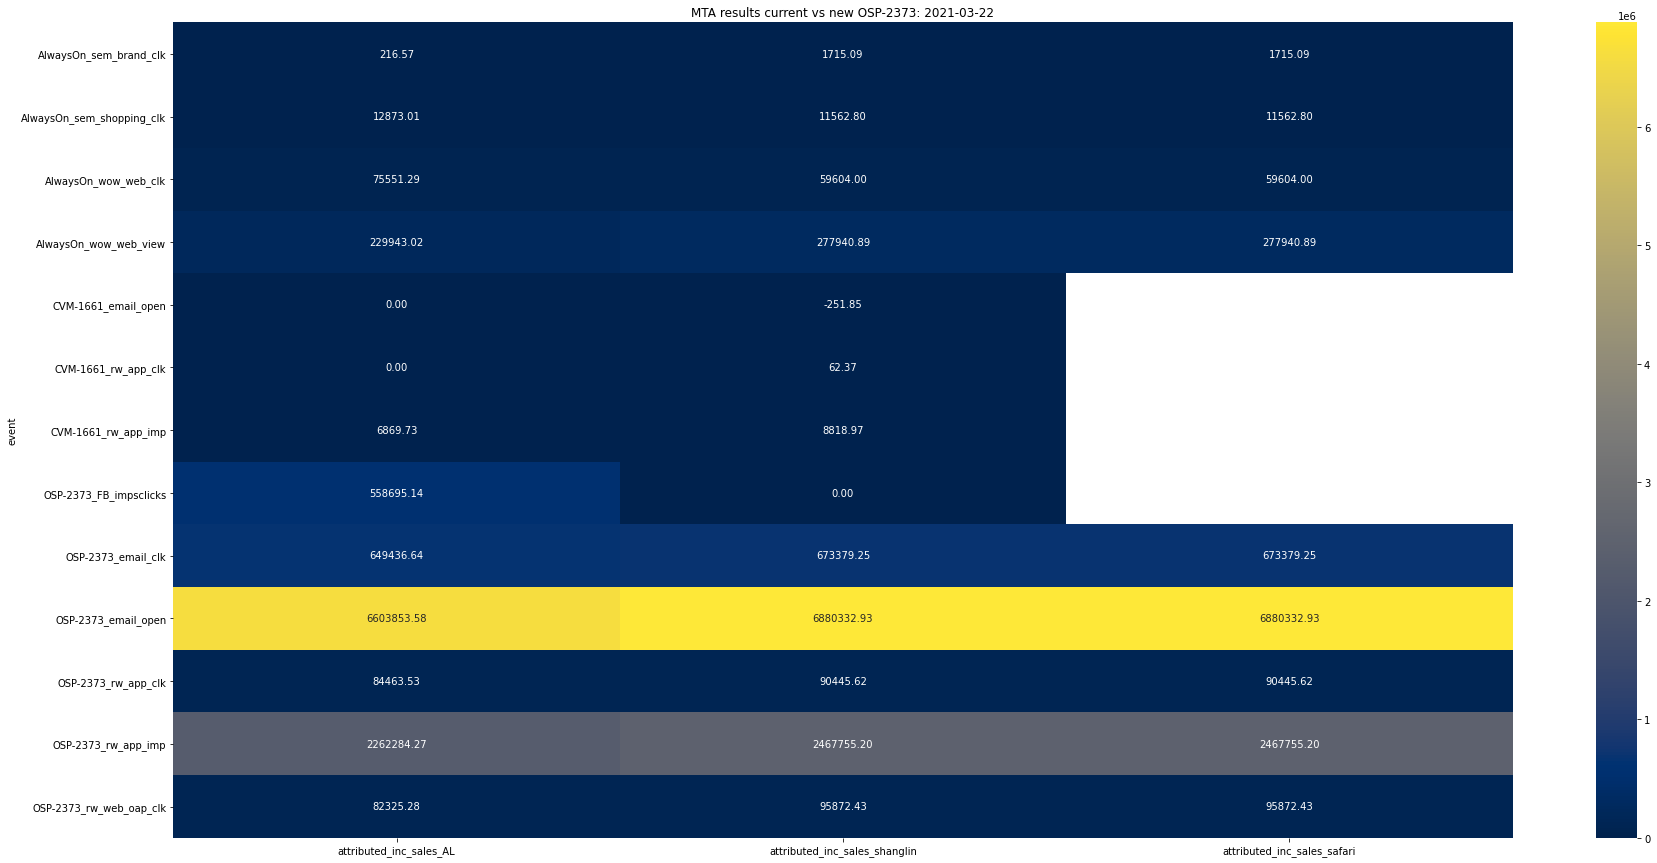

(                           channel_prob_norm_AL  channel_prob_norm_shanglin  \
 event                                                                         
 AlwaysOn_sem_brand_clk                 0.000100                    0.003626   
 AlwaysOn_sem_shopping_clk              0.002346                    0.013307   
 AlwaysOn_wow_web_clk                   0.031633                    0.080746   
 AlwaysOn_wow_web_view                  0.041961                    0.176567   
 CVM-1661_email_open                    0.000000                    0.001211   
 CVM-1661_rw_app_clk                    0.000000                    0.003242   
 CVM-1661_rw_app_imp                    0.007101                    0.028175   
 OSP-2373_FB_impsclicks                -2.000000                    0.000000   
 OSP-2373_email_clk                     0.215444                    0.392974   
 OSP-2373_email_open                    0.253439                    0.712036   
 OSP-2373_rw_app_clk                    

In [81]:
run_downstream_process(fpath_results="01_results/res_w_fb_weighted_2_OSP-2373_2021-03-22_2021-03-28_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-03-22",
                       safari_run_date="2021-03-31",
                       create_dacamp_prod_mc_final=True,
                       have_historical_marketable_crn=False,
                       which_mc_crn_output="Weixing",
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_w_fb_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_2021-03-15_OSP-2373`
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-03-15_OSP-2373`
>>> Step 3: Compare results to BAU run


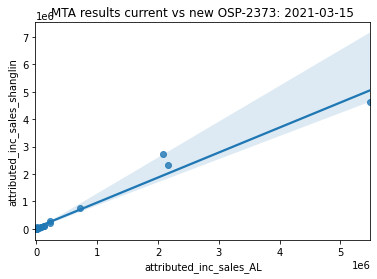

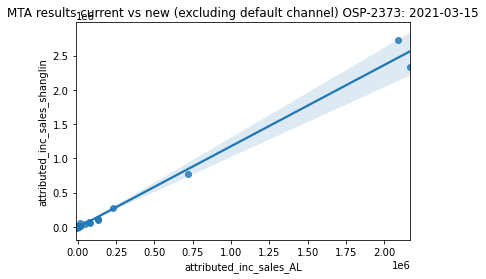

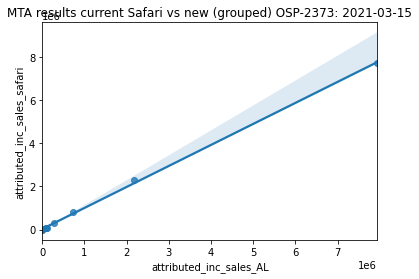

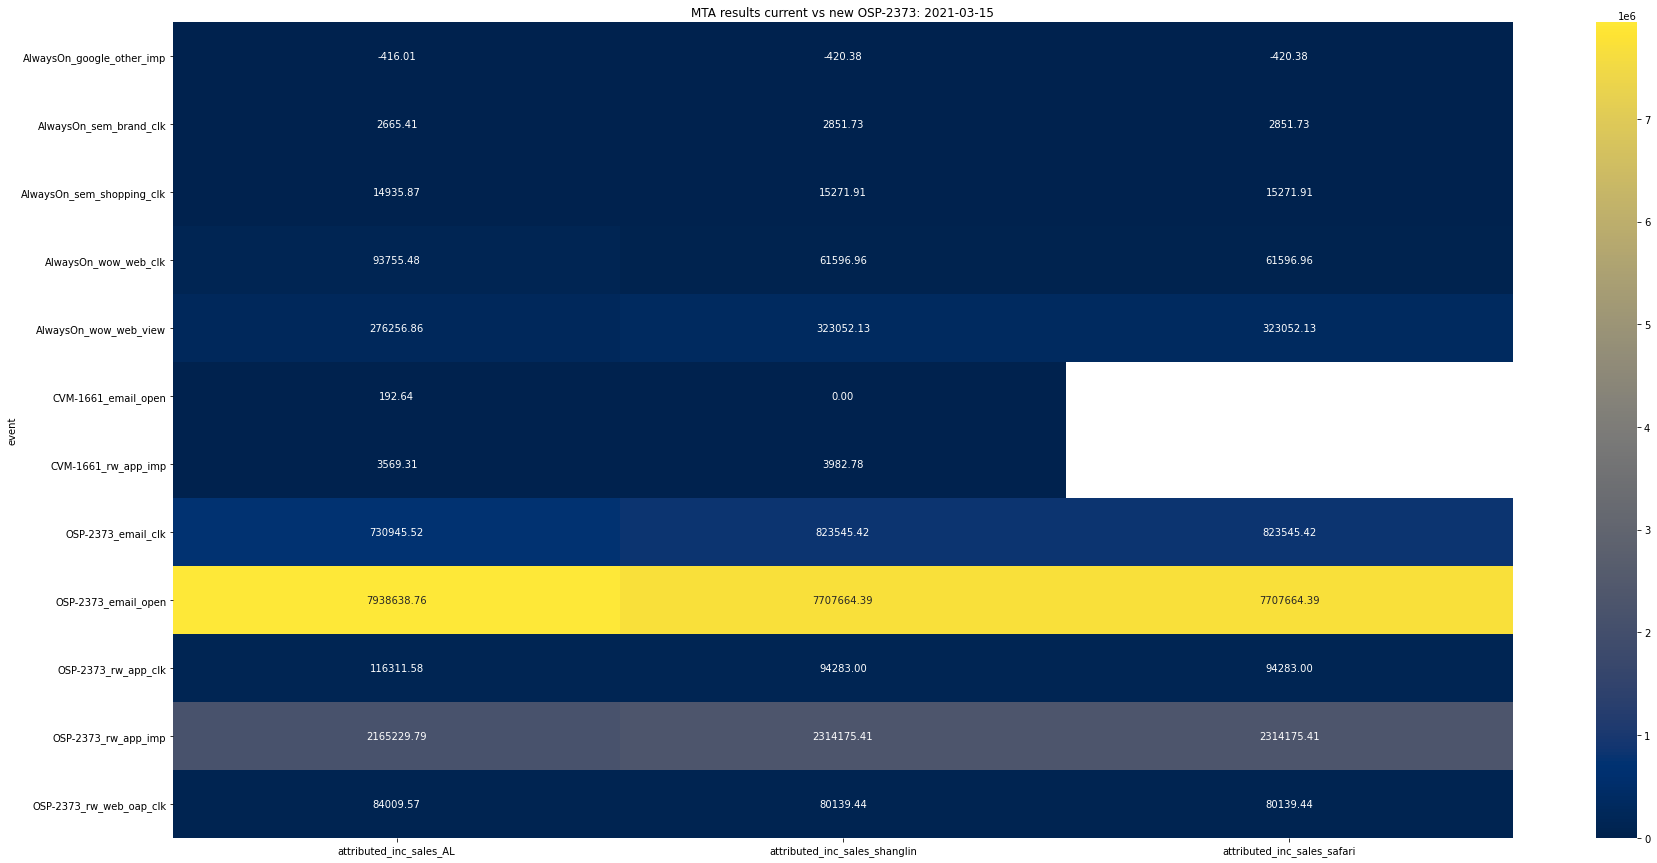

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-03-15 ... end of fw is 2021-03-21
	FB scaling ratio is (for missing slice of pie) 0.0
	FB attribution ratio is 0.0
	non-FB attribution ratio is 1.0
	fb inc sales for OSP-2373 increased by 3.325542262716282e-14
	touchpoint count increased by 570225
	exported dacamp_prod_mc_final_crn_w_fb to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-03-15_OSP-2373`


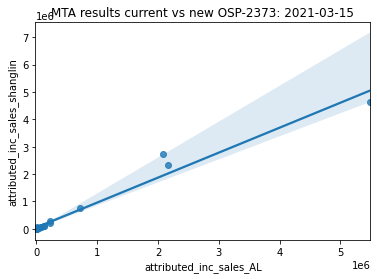

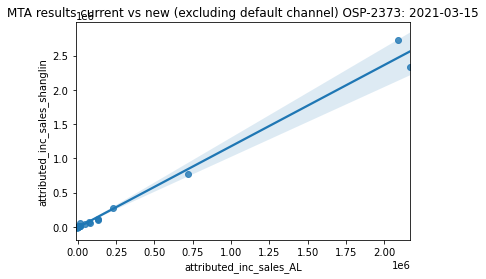

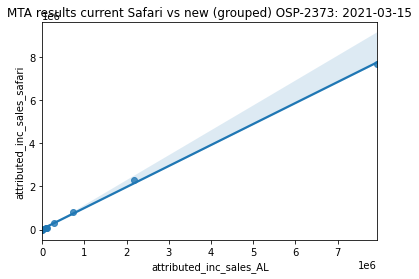

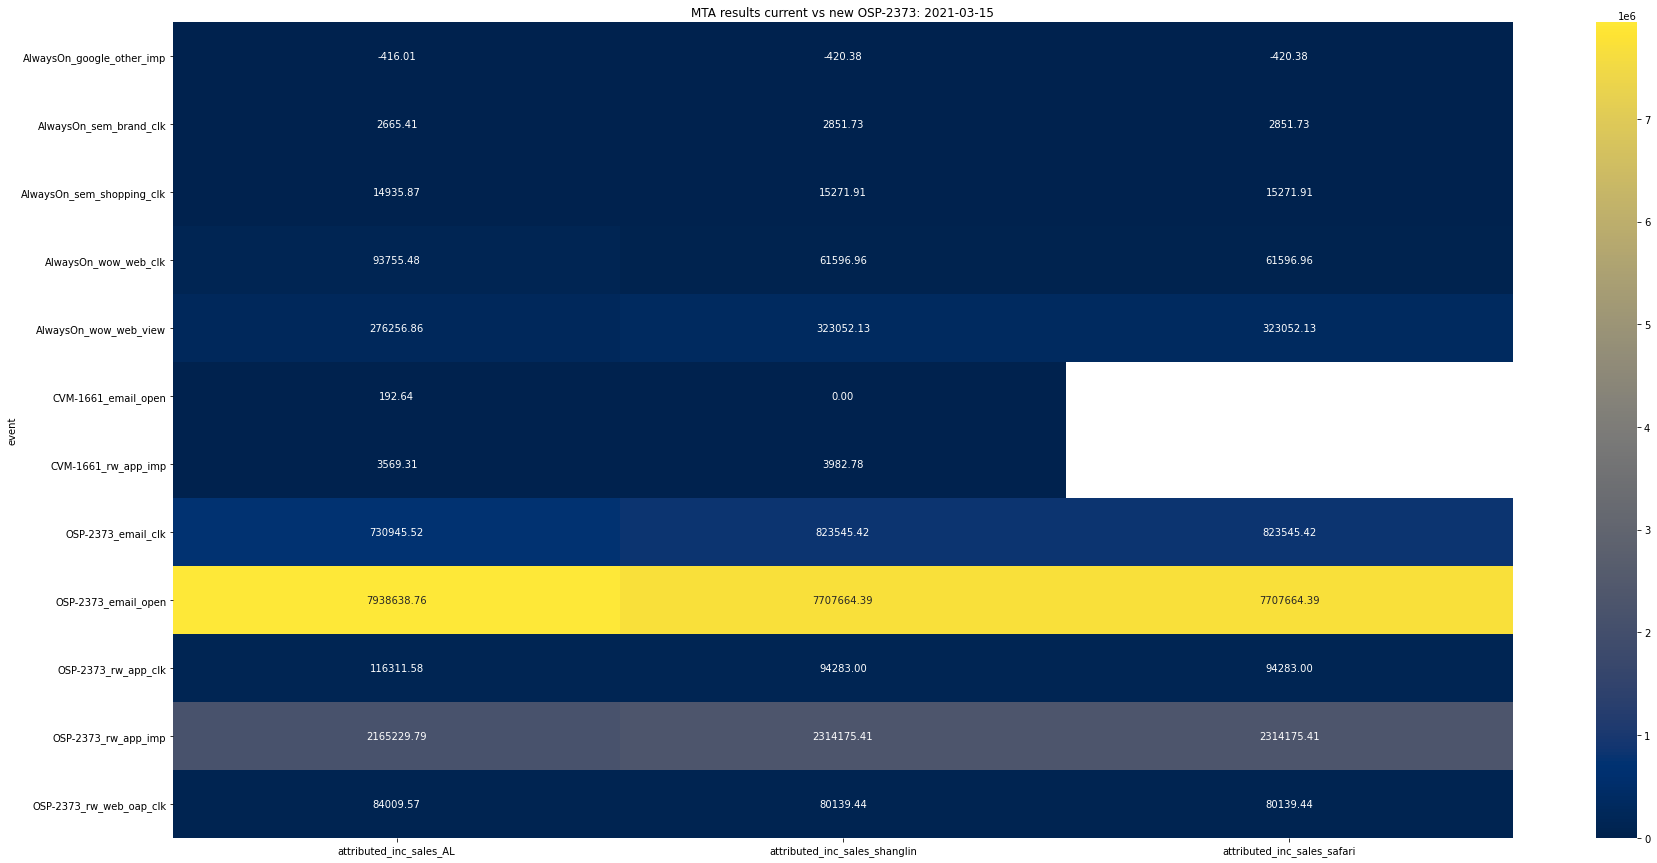

(                           channel_prob_norm_AL  channel_prob_norm_shanglin  \
 event                                                                         
 AlwaysOn_google_other_imp              0.000112                    0.001275   
 AlwaysOn_sem_brand_clk                 0.000134                    0.004582   
 AlwaysOn_sem_shopping_clk              0.003817                    0.014233   
 AlwaysOn_wow_web_clk                   0.036805                    0.085127   
 AlwaysOn_wow_web_view                  0.044404                    0.172724   
 CVM-1661_email_open                    0.000427                    0.000000   
 CVM-1661_rw_app_imp                    0.003439                    0.006257   
 OSP-2373_email_clk                     0.224773                    0.418362   
 OSP-2373_email_open                    0.269456                    0.721155   
 OSP-2373_rw_app_clk                    0.085949                    0.077263   
 OSP-2373_rw_app_imp                    

In [83]:
run_downstream_process(fpath_results="01_results/res_w_fb_weighted_OSP-2373_2021-03-15_2021-03-21_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-03-15",
                       safari_run_date="2021-03-24",
                       create_dacamp_prod_mc_final=True,
                       have_historical_marketable_crn=False,
                       which_mc_crn_output="Weixing",
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_w_fb_weighted")

# Check before upload

In [ ]:
old_new_mapping = {"`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-04-12`":"`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-04-12_OSP-2373`",
                   "`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-04-12`":"`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-04-12_OSP-2373`",
                   "`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-04-12`":"`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-04-12_OSP-2373`",
                   "`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-04-12`":"`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-04-12_OSP-2373`",
                   "`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-04-12`":"`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-04-12_OSP-2373`",
                   "`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-04-12`":"`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-04-12_OSP-2373`",
                   "`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-04-12`":"`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-04-12_OSP-2373`",
                  }

In [37]:
# dacamp_prod_mc_final_crn_old="`wx-bq-poc.digital_attribution_modelling.dacamp_prod_mc_final_crn`"
dacamp_prod_mc_final_crn_old="`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-04-12`"
# dacamp_prod_mc_final_crn_new="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-05-17_OSP-2373`"
dacamp_prod_mc_final_crn_new="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-04-12_OSP-2373`"
campaign_code="OSP-2373"
query_string = """
  -- CHECK
WITH
  table_a AS (
  SELECT
    campaign_code,
    channel,
    medium,
    event,
    SUM(attributed_inc_sales) AS attributed_inc_sales,
    COUNT(*) AS count
  FROM
    {dacamp_prod_mc_final_crn_new}
  GROUP BY
    1,
    2,
    3,
    4 ),
  table_b AS (
  SELECT
    campaign_code,
    channel,
    medium,
    event,
    SUM(attributed_inc_sales) AS attributed_inc_sales,
    COUNT(*) AS count
  FROM
    {dacamp_prod_mc_final_crn_old}
  WHERE
    campaign_code="{campaign_code}"
  GROUP BY
    1,
    2,
    3,
    4 )
SELECT
  coalesce(a.campaign_code,
    b.campaign_code) as campaign_code,
  coalesce(a.channel,
    b.campaign_code) as channel,
  coalesce(a.medium,
    b.medium) as medium,
  coalesce(a.event,
    b.event) as event,
  a.attributed_inc_sales AS attributed_inc_sales_new,
  b.attributed_inc_sales AS attributed_inc_sales_old,
  a.count AS count_new,
  b.count AS count_old
FROM
  table_a AS a
FULL OUTER JOIN
  table_b AS b
ON
  a.channel = b.channel
  AND a.medium = b.medium
  AND a.event = b.event;
""".format(dacamp_prod_mc_final_crn_old=dacamp_prod_mc_final_crn_old,
           dacamp_prod_mc_final_crn_new=dacamp_prod_mc_final_crn_new,           
           campaign_code=campaign_code)
df_bq = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)


In [38]:
df_bq

campaign_code                 channel                  medium  \
0       OSP-2373  _AlwaysOn_google_other  _AlwaysOn_google_other   
1       OSP-2373           _AlwaysOn_sem  _AlwaysOn_sem_shopping   
2       OSP-2373       _AlwaysOn_wow_web       _AlwaysOn_wow_web   
3       OSP-2373         OSP-2373_rw_app         OSP-2373_rw_app   
4       OSP-2373          OSP-2373_email          OSP-2373_email   
5       OSP-2373     OSP-2373_rw_web_oap     OSP-2373_rw_web_oap   
6       OSP-2373       _AlwaysOn_wow_web       _AlwaysOn_wow_web   
7       OSP-2373         CVM-1661_rw_app         CVM-1661_rw_app   
8       OSP-2373          OSP-2373_email          OSP-2373_email   
9       OSP-2373         OSP-2373_rw_app         OSP-2373_rw_app   
10      OSP-2373                OSP-2373         CVM-1661_rw_app   
11      OSP-2373           _AlwaysOn_sem     _AlwaysOn_sem_brand   
12      OSP-2373             OSP-2373_FB             OSP-2373_FB   
13      OSP-2373          CVM-1661_email          CVM-1661_email   

                         event  attributed_inc_sales_new  \
0   _AlwaysOn_google_other_imp              1.537709e+02   
1   _AlwaysOn_sem_shopping_clk              5.730549e+03   
2       _AlwaysOn_wow_web_view              3.366465e+05   
3          OSP-2373_rw_app_clk              1.502009e+05   
4          OSP-2373_email_open              7.060454e+06   
5      OSP-2373_rw_web_oap_clk              6.256230e+04   
6        _AlwaysOn_wow_web_clk              2.198910e+05   
7          CVM-1661_rw_app_imp              2.095748e+04   
8           OSP-2373_email_clk              8.913364e+05   
9          OSP-2373_rw_app_imp              3.190894e+06   
10         CVM-1661_rw_app_clk                       NaN   
11     _AlwaysOn_sem_brand_clk              2.114355e+02   
12      OSP-2373_FB_impsclicks              7.822992e+05   
13         CVM-1661_email_open              2.218508e+02   

    attributed_inc_sales_old  count_new  count_old  
0                        NaN       45.0        NaN  
1               6.426308e+03     1371.0     1371.0  
2               4.840487e+05    20320.0    20320.0  
3               1.085073e+05    29738.0    29738.0  
4               7.683881e+06   344327.0   344156.0  
5               7.116889e+04     9764.0     9764.0  
6               1.436186e+05     9897.0     9897.0  
7               2.586890e+04     9874.0     9874.0  
8               8.450578e+05   137755.0   137755.0  
9               3.352295e+06   149459.0   149459.0  
10              1.741215e+01        NaN      495.0  
11              2.514706e+02      137.0       85.0  
12                       NaN   408413.0        NaN  
13                       NaN      227.0        NaN